In [1]:
import numpy as np
import os
import requests
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.cm as mcm
import matplotlib.colors as mcol
from matplotlib.patches import Ellipse
import numpy.ma as nma
import petrofit as ptf
from astropy.io import fits
from astropy.visualization import ManualInterval,LogStretch
from astropy.cosmology import Planck18 as cosmo
import time

from photutils.psf import MoffatPSF
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources, SourceFinder, SourceCatalog
from photutils.utils import circular_footprint
from astropy.convolution import convolve

import statmorph
from make_rgb import *

plt.style.use('./presentation.mplstyle')

In [2]:
sources = pd.read_csv('v1saga_dwarfs.csv')
print(np.shape(sources))
#download_cutout(sources)

(6337, 26)


In [19]:
rd2deg = (180*3600)/np.pi
pixsc = 0.262
npix = 128

def read_sources(filename,Nsamp=0):
    data = np.genfromtxt(filename, delimiter=',',skip_header=True)

    if Nsamp>0: data = data[npr.choice(len(data), Nsamp)]
    return data

def request_apply(url,filename,out_dir):
    if not os.path.exists(out_dir+filename):
                print(url)
                print('downloading -- ', filename) 

                response = requests.get(url)
                
                if response.status_code == 200:
                    with open(out_dir+filename, 'wb') as file:
                        file.write(response.content)


def download_cutout(sample, size=npix,out_dir='cutouts/'):

    for j in range(len(sample)):
        ra,dec = sample[j,0],sample[j,1]
        filename = 'cutout_{:.4f}_{:.4f}.fits'.format(ra,dec)

        if dec<32.375:
            url = ('https://www.legacysurvey.org/viewer/fits-cutout?ra={:.4f}&dec={:.4f}&size='+str(size)+'&layer=ls-dr10-south&invvar&pixscale=0.262&bands=griz').format(ra,dec)
        else:
            url = ('https://www.legacysurvey.org/viewer/fits-cutout?ra={:.4f}&dec={:.4f}&size='+str(size)+'&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz').format(ra,dec)
        
        request_apply(url,filename,out_dir) 


def image_plot(ax,img,cmp):
    m, s = np.mean(img), np.std(img)
    ax.imshow(img, interpolation='nearest', cmap=cmp, vmin=m-s, vmax=m+s, origin='lower')

def rgb_cutout(img_data):
    imax = 0
    for img in img_data[::-1]:
        val = np.percentile(img,99.5)
        if val > imax: imax = val
    
    clip_intvls = 3*[ManualInterval(vmin=0, vmax=imax)]
    clip_intvls[2] = ManualInterval(vmin=0, vmax=2*imax)
    
    return make_rgb(img_data[2],img_data[1],img_data[0],interval=clip_intvls,stretch=LogStretch(a=20))

def signal_to_noise(X,N,M):
    Y = np.abs(np.multiply(X,M))
    return np.sum(Y/N)/np.sum(M)

def image_bkg(img_dat):
    img_sub,img_rms = np.zeros((4,npix,npix)),np.zeros((4,npix,npix))
    glob_rms = np.zeros(4)

    img_arr = img_dat[0].data
    img_hdr = img_dat[0].header
    img_invvar = img_dat[1].data

    w = wcs.WCS(img_hdr,naxis=2)

    flags=[False]*4 

    #fig,ax=plt.subplots(2,len(c),figsize=(6*len(c),14),sharey=True)
    if np.shape(img_arr)[0]==4: ixr,ir=range(4),range(4)
    else: 
        flags[2] = True
        ixr,ir=range(3),[0,1,3]
        
    for i,ix in zip(ir,ixr):    
        threshold = detect_threshold(img_arr[ix,:,:], nsigma=1.0)
        segment_img = detect_sources(img_arr[ix,:,:], threshold, npixels=10,connectivity=8)

        try: mask = segment_img.make_source_mask(size=2)
        except: 
            flags[i]=True
            continue
        
        var = np.reciprocal(img_invvar[ix,:,:])
        bkg = Background2D(img_arr[ix,:,:].astype(img_arr[ix,:,:].dtype.newbyteorder('=')), ( 32, 32), filter_size=(5,5), mask=mask)

        if np.mean(var)>100 or np.any(var<0): flags[i]=True
        #print(key+' Background:',bkg.background_median,key+' RMS^2:',np.square(bkg.background_rms_median),key+' Var:',np.mean(var))

        img_sub[i] = img_arr[ix,:,:]-np.abs(bkg.background)
        img_rms[i] = np.sqrt(var)
        glob_rms[i] = bkg.background_median

    #plt.subplots_adjust(wspace=0.0,hspace=0.05)
    #plt.show()

    return img_sub, img_hdr, img_rms, glob_rms, flags

def image_segmap(img_dat,img_rms,psf_mod,wc,flags):
        segmaps_lo,segmaps_hi = np.zeros((4,npix,npix)),np.zeros((4,npix,npix))
        cat_list = []
   
        for ii,key in enumerate(bands):        
                if flags[ii]==True: continue
                #image_plot(ax[jj],img_data[jj],cmp=mcm.Greys)
                convolved_data = convolve(img_data[ii], psf_mod)

                finder = SourceFinder(npixels=10, nlevels=32, contrast=0.0005, progress_bar=False)
                segment_map = finder(convolved_data, img_rms[ii])

                if segment_map==None: 
                    flags[jj]=True
                    continue
        
                cat = SourceCatalog(img_data[ii], segment_map, convolved_data=convolved_data)
                tbl = cat.to_table()                    
                    
                target = np.argmin(np.sqrt((tbl['xcentroid']-wc[0])**2+(tbl['ycentroid']-wc[1])**2))
                segmaps_lo[ii] = (1*(segment_map==(target+1)))
                segmaps_hi[ii] = (1*((segment_map!=imzer)&(segment_map!=(target+1))))
                '''
                flux_arr, area_arr, error_arr = ptf.source_photometry(cat[target], img_data[jj], segment_map, r_list, error=img_rms[jj],bg_sub=False, plot=False)
                petr = ptf.Petrosian(r_list, area_arr, flux_arr, flux_err=error_arr)
                print("{:0.4f} ± {:0.4f} pix".format(petr.r_petrosian, petr.r_petrosian_err))
                '''

        if not (flags[0] or flags[1]): 
            comp_segmap = 1* (np.logical_and(segmaps_lo[0],segmaps_lo[1])&(np.logical_xor(segmaps_lo[2],flags[2])|np.logical_xor(segmaps_lo[3],flags[3])))
            comp_mask = 1* np.logical_or(np.logical_or(segmaps_hi[0],segmaps_hi[1]),np.logical_or(segmaps_hi[2],segmaps_hi[3]))
        else: flags= [True]*4
        if comp_segmap[npix//2 -1,npix//2 -1]<1: flags= [True]*4
        
        return comp_segmap,comp_mask,flags

def plot_cutout(img_data,comp_segmap,pos,w,ptr,df_row):
        fig,ax=plt.subplots(figsize=(16,8))
        img_copy = [img_data[k].copy() for k in [0,1,3]]
        ax.imshow(rgb_cutout(img_copy), origin='lower',extent=[pos[0]-16.506,pos[0]+16.506, pos[1]-16.506, pos[1]+16.506])

        for k in range(3): np.putmask(img_copy[k],~(comp_segmap.astype('bool')),0)
        ax.imshow(rgb_cutout(img_copy), origin='lower',extent=[pos[0]-16.506,pos[0]+16.506, pos[1]-16.506, pos[1]+16.506],alpha=0.5)

        #ax.scatter(pos_asymm[0], pos_asymm[1],marker='*',color='red',s=40,zorder=101)

        e = Ellipse(xy=w.pixel_to_world_values(ptr[0], ptr[1]),width=2*ptr[2]*pixsc, height=2*ptr[2]*(1-ptr[4])*pixsc,
                angle=ptr[3] * 180/np.pi,lw=2, fill=False,color='azure',ls='--')
        ax.add_artist(e)
        
        ax.text(pos[0]-16.5,pos[1]-14.5,r'${{\rm log}}M_{{\ast}}={0:.2f}$'.format(df_row['logM']),fontsize=30,color='white')
        ax.text(pos[0]+2.5,pos[1]-14.5,r'$z ={0:.2f}$'.format(df_row['zspec']),fontsize=30,color='white')
        ax.text(pos[0]+2.5,pos[1]+12.5,r'${{\it g-r}}={0:.2f}$'.format(df_row['g-r']),fontsize=30,color='white')

        ax.set_xlabel(r'$RA \ (deg)$',fontsize=40)
        ax.set_ylabel(r'$DEC \ (deg)$',fontsize=40)

        plt.savefig('post_cutouts/galseg_{:.4f}_{:.4f}.png'.format(pos[0],pos[1]),bbox_inches='tight')
        plt.show()

def gaussian_2d(x, y, x0=0.0, y0=0.0, sigma=1.0): return np.exp(-((x - x0)**2 + (y - y0)**2)/(2*sigma**2))

def elliptical_transform(x,y,rp,th,e): return np.sqrt(np.square((x*np.cos(th)+y*np.sin(th))/rp) + np.square((x*np.sin(th)-y*np.cos(th))/(rp*(1-e))))

def psf_grid(d_psf,fwhm, psf_type='gaussian'):
    x = np.arange(-d_psf, d_psf+1)
    y = np.arange(-d_psf, d_psf+1)
    x_grid, y_grid = np.meshgrid(x, y)
    
    if psf_type=='gaussian':
            psf = gaussian_2d(x_grid, y_grid, sigma=fwhm)
            return psf/np.sum(psf)
    elif psf_type=='moffat':
            model = MoffatPSF(x_0=0.0, y_0=0.0, alpha=fwhm, beta=2.0)
            psf = model(x_grid, y_grid)
            return psf/np.sum(psf)



1200 [122.976241   36.3223408] 0.08269 8.642


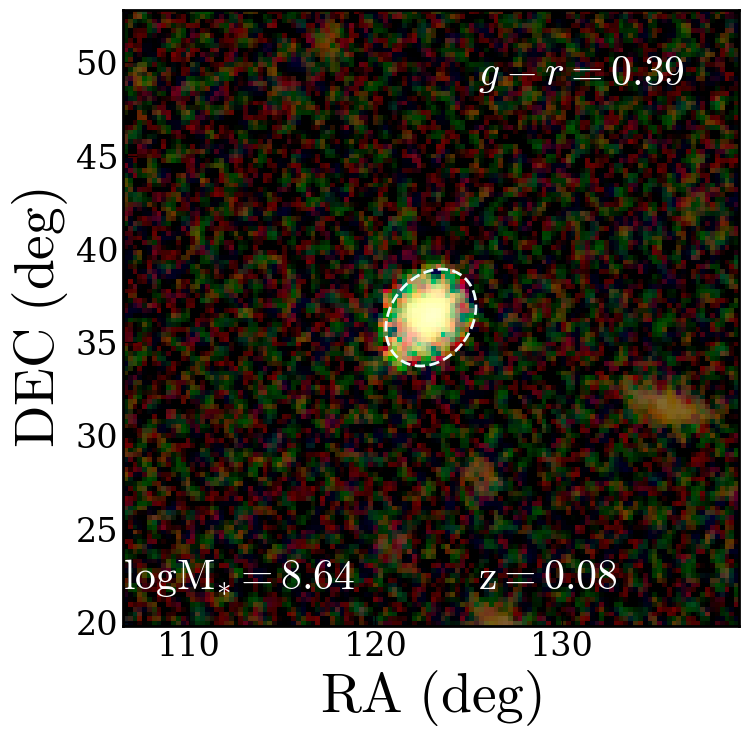

1201 [122.9844421  36.3251785] 0.08248 9.169


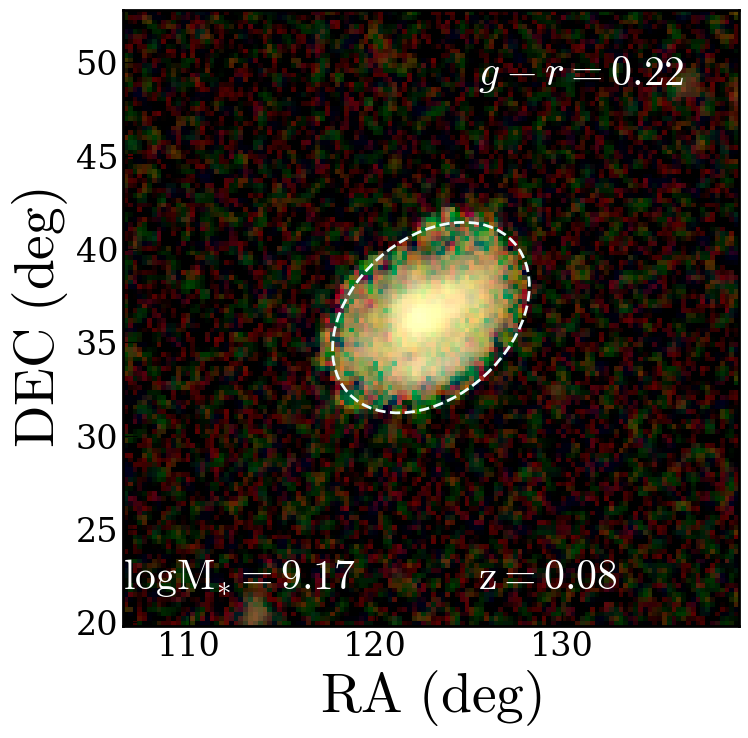

1202 [122.9921441  36.2080669] 0.08715 10.056


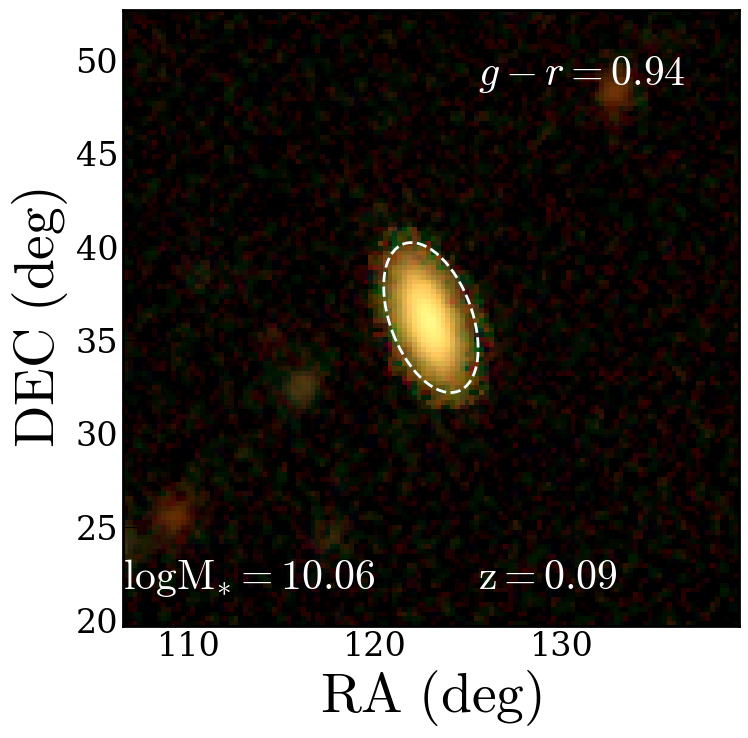

1203 [123.000428   36.3630951] 0.08339 8.578


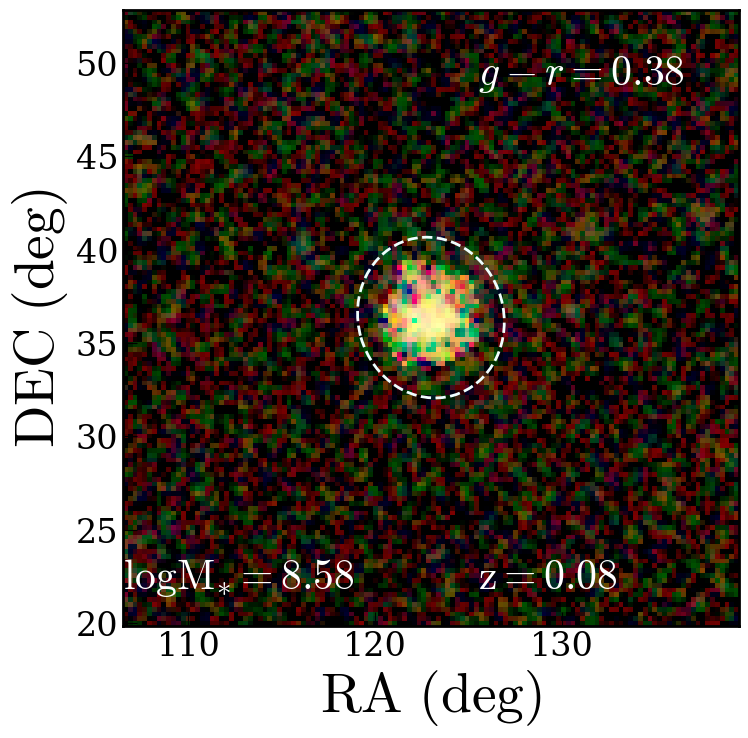

1204 [123.016343   36.3645891] 0.08265 9.626


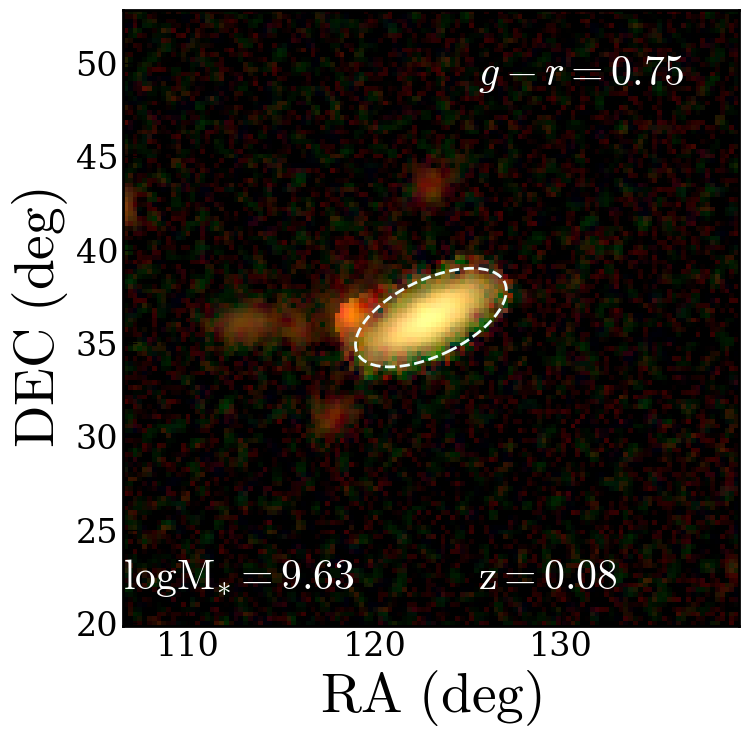

1205 [123.034975  36.370279] 0.04213 8.989


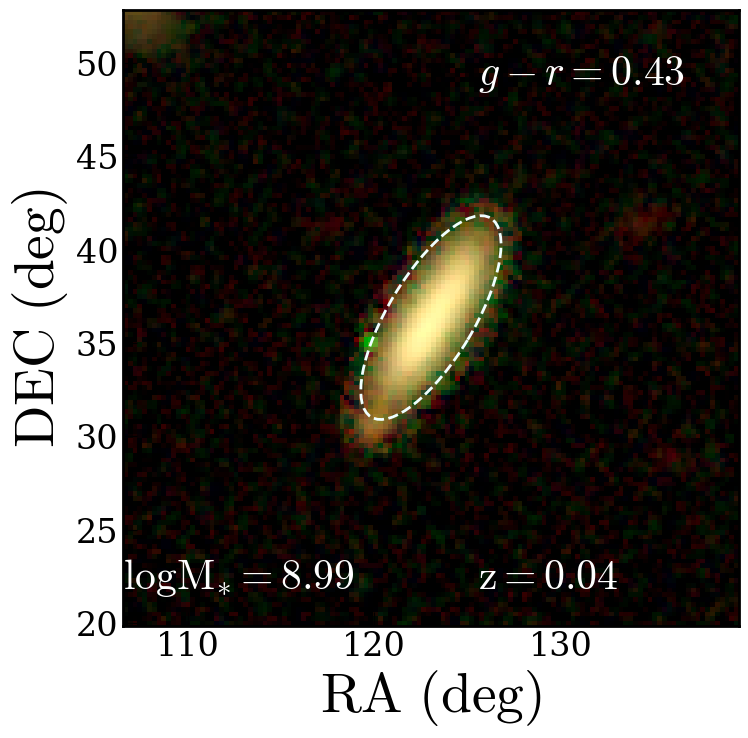

1206 [123.046984   36.2616193] 0.02323 8.346


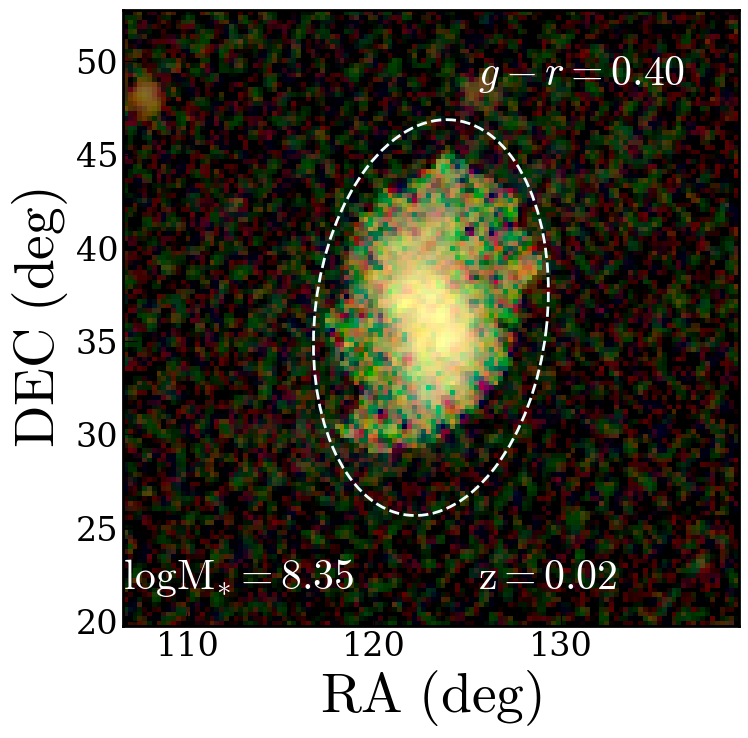

1207 [123.0867595  35.829274 ] 0.08179 8.83


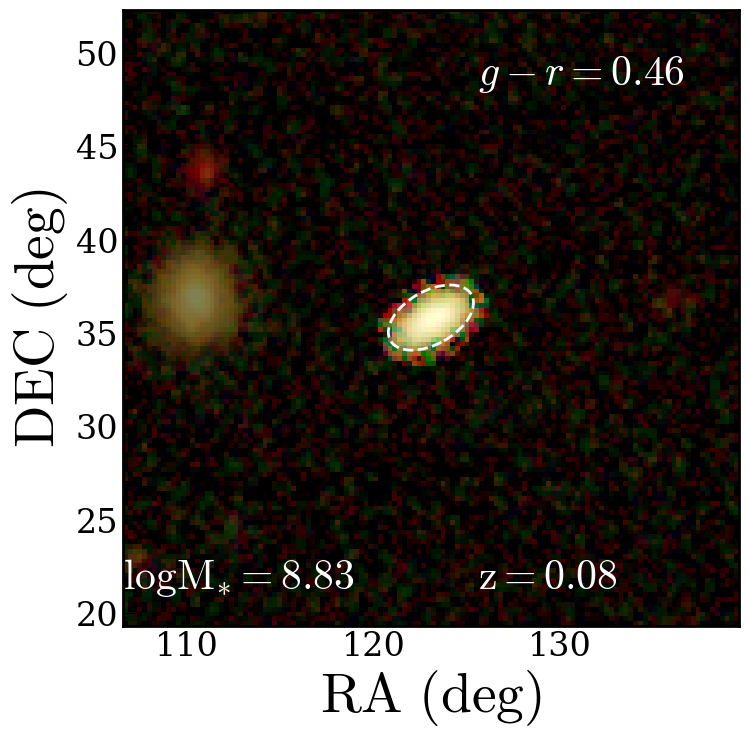

1208 [122.9661419  36.3926736] 0.04179 8.215


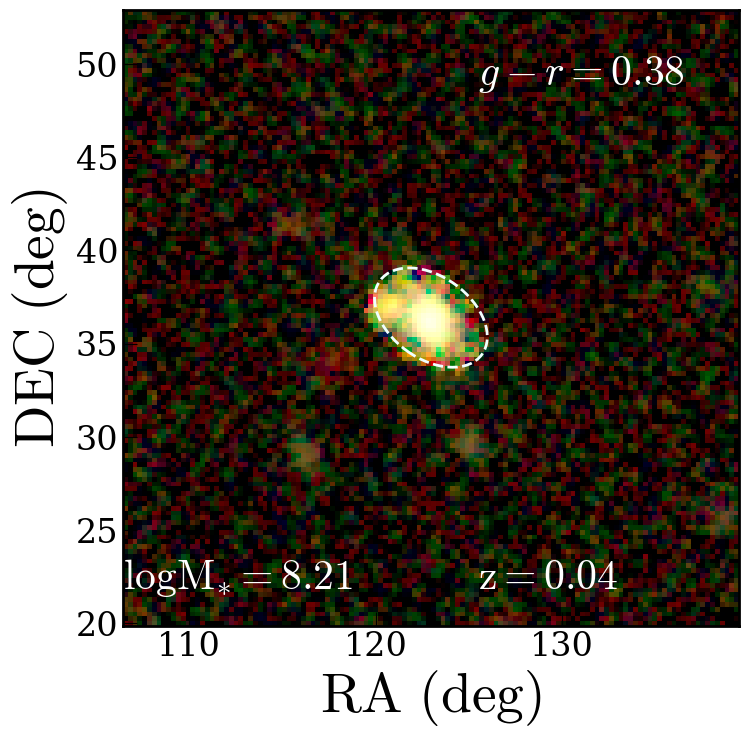

1209 [123.0076381  36.4072301] 0.08622 9.744


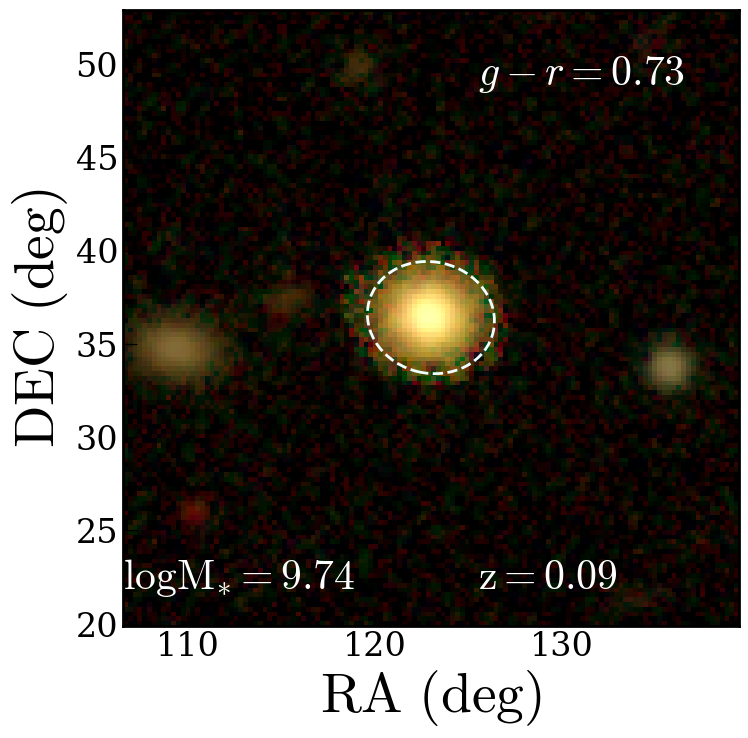

1210 [123.1152252  36.4226788] 0.08231 9.125


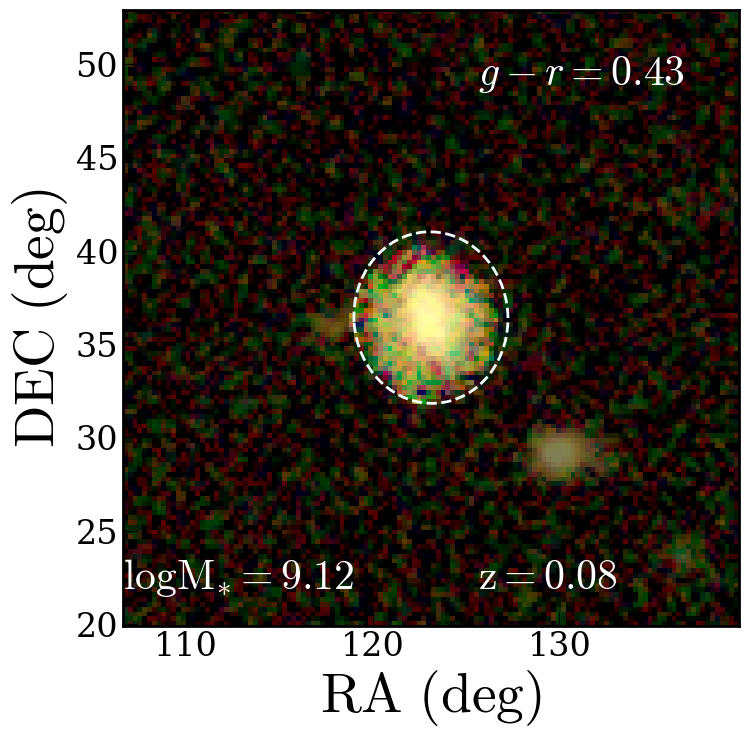

1211 [123.1759126  36.4813205] 0.08593 9.129


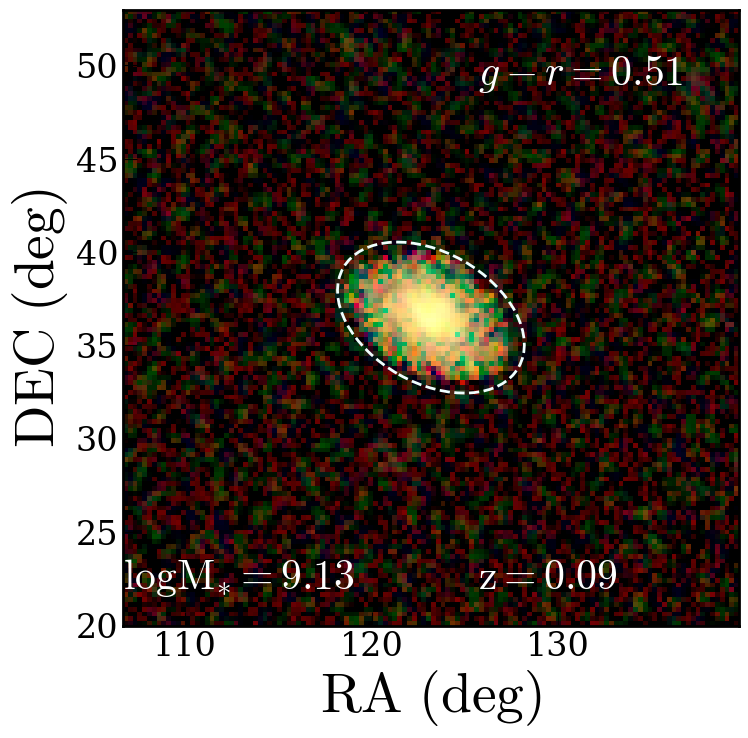

1212 [123.2016856  36.4683121] 0.04188 7.913


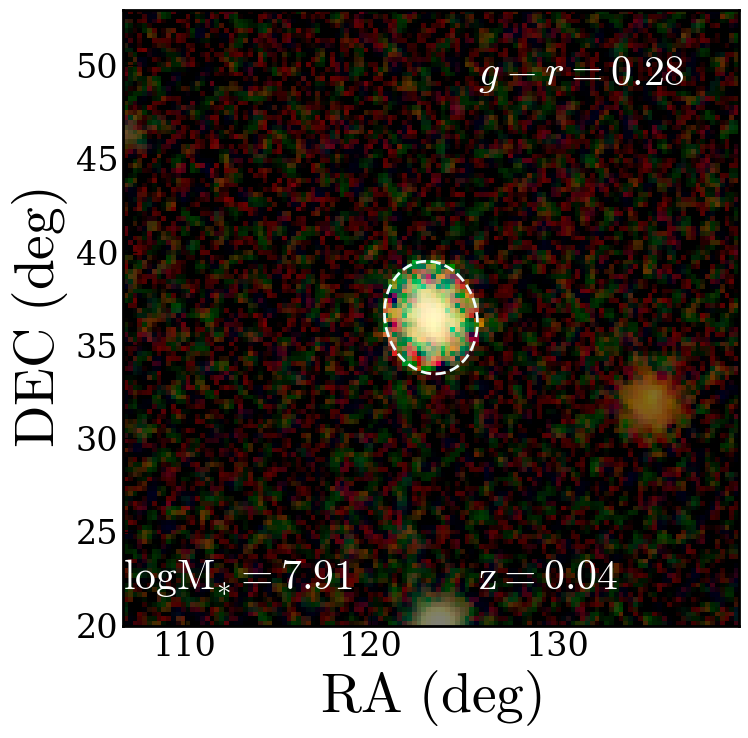

1213 [122.9820408  35.8934504] 0.08176 9.892


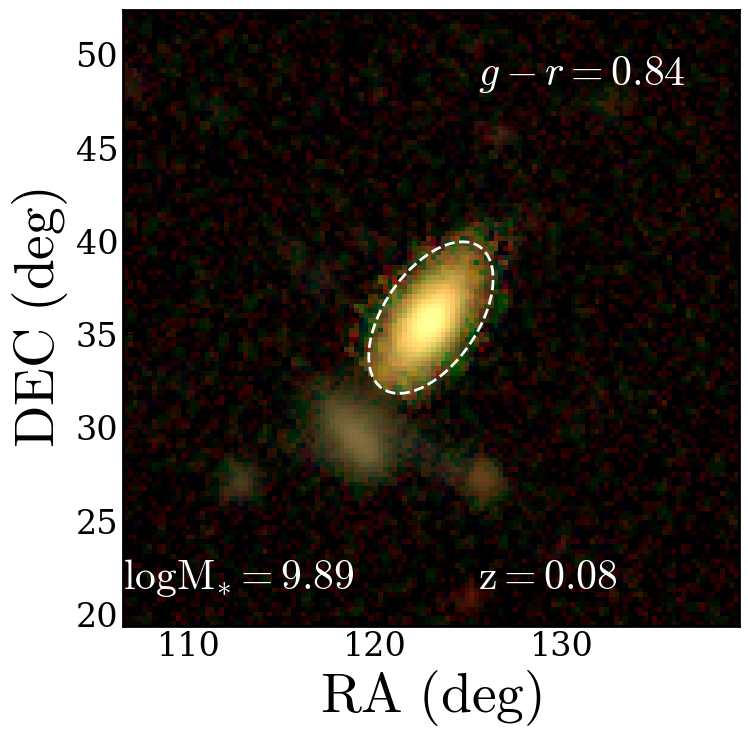

1214 [122.9889669  35.9444397] 0.07791 8.862


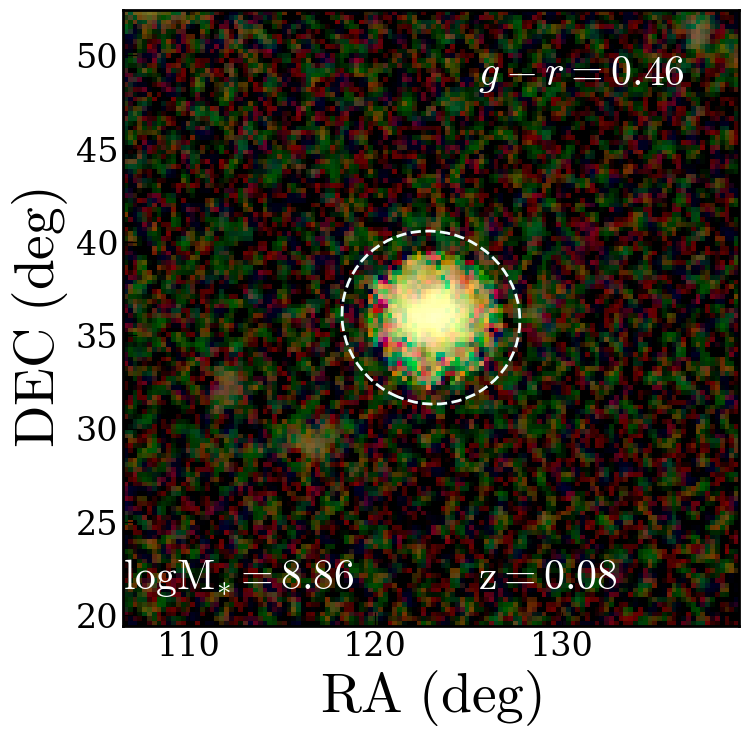

1215 [123.0220933  36.1096648] 0.07804 8.904


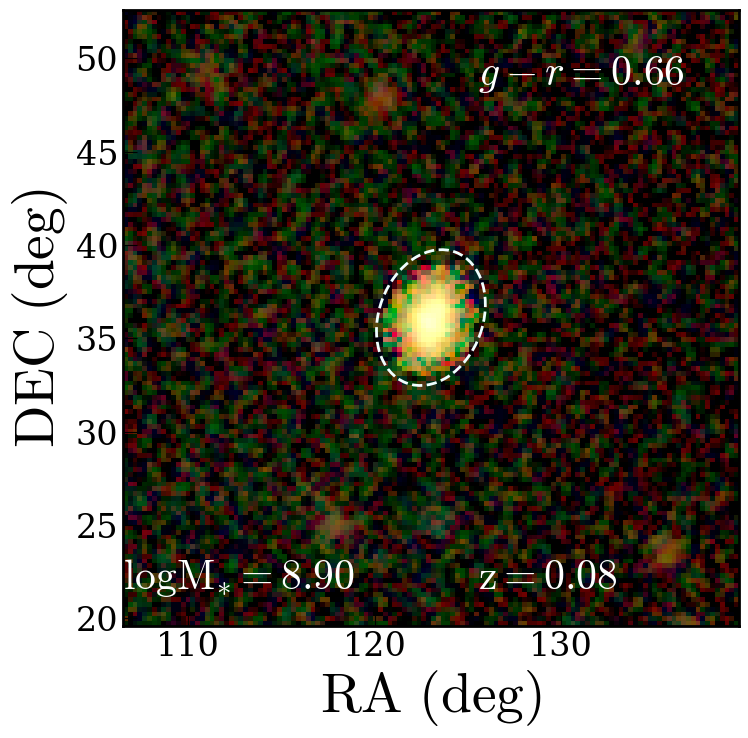

1216 [123.0410807  36.0385667] 0.07872 8.716


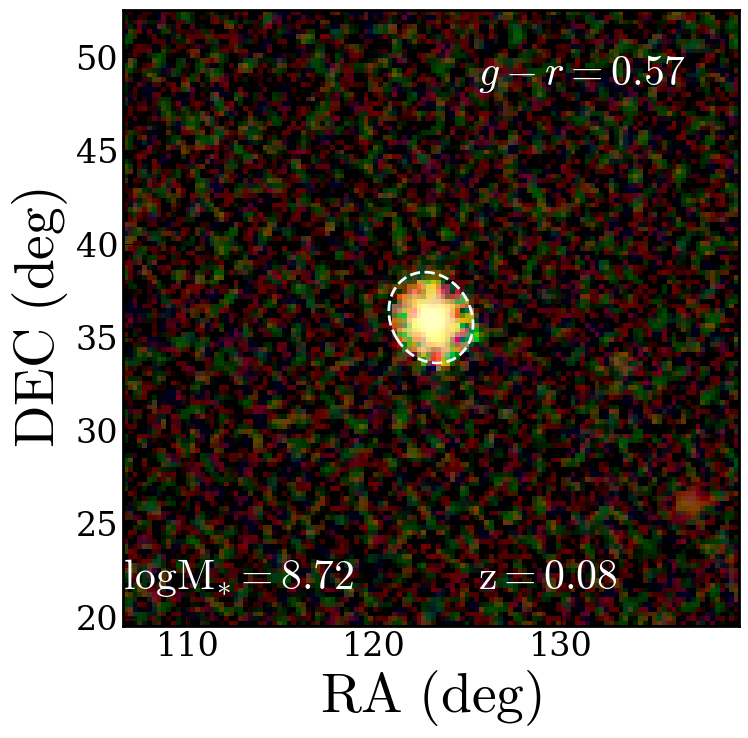

1217 [123.0497446  36.0999604] 0.08612 9.415


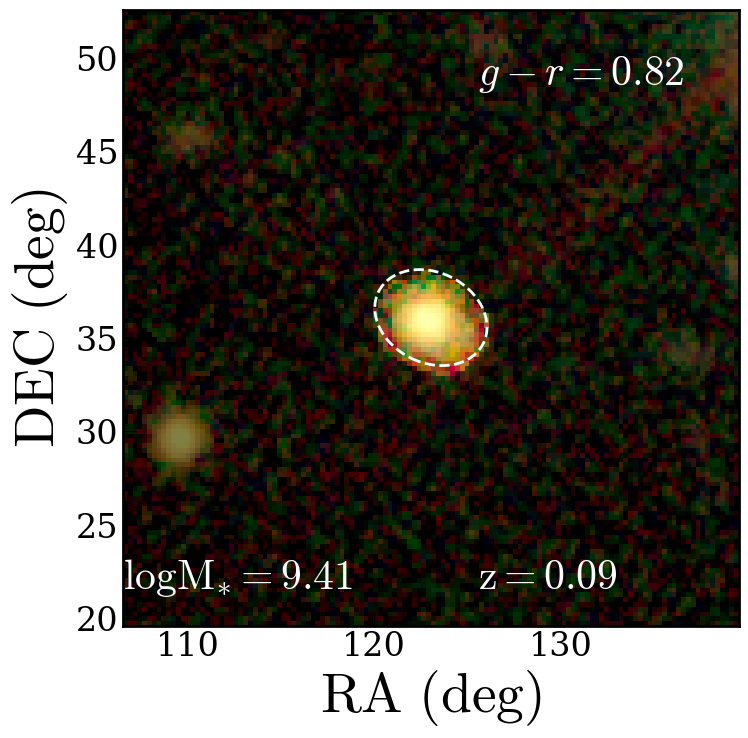

1218 [123.057619   35.9316213] 0.08368 9.63


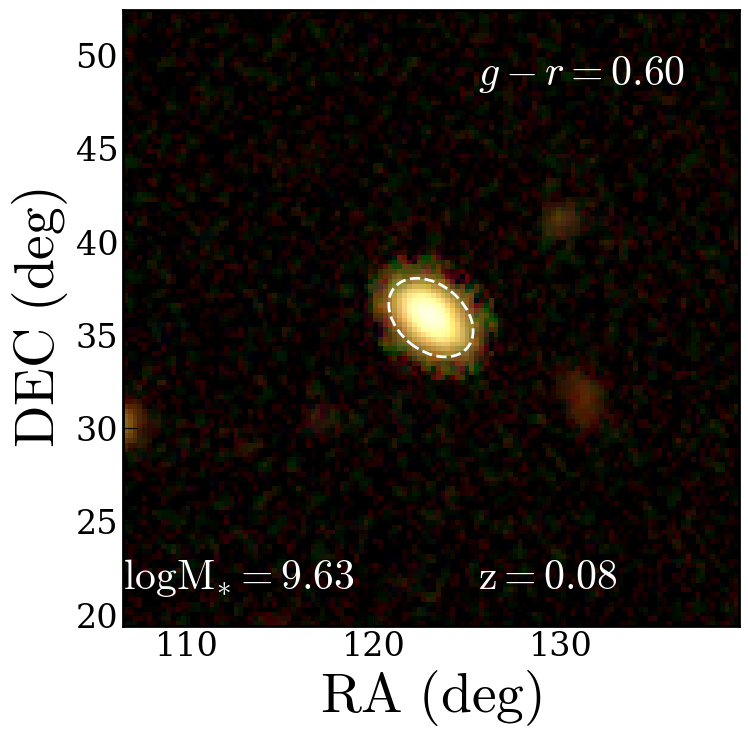

1219 [123.0950551  35.9388394] 0.08399 9.023


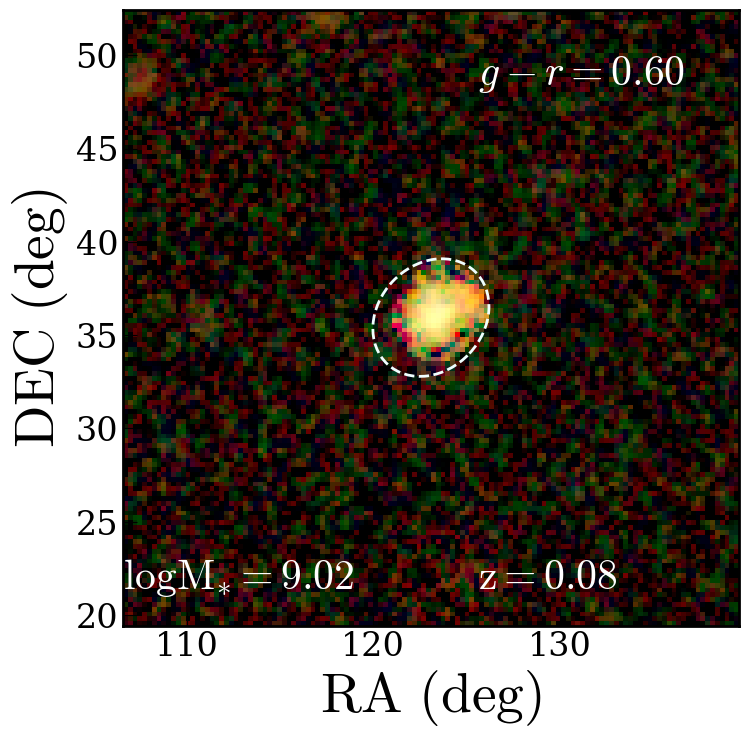

1220 [123.116069   35.9804612] 0.08239 9.624


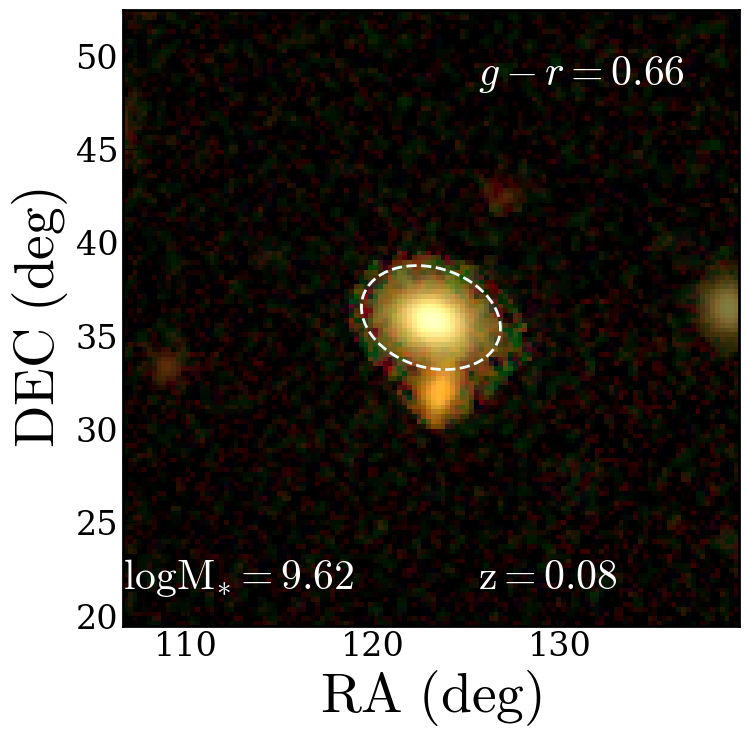

1221 [123.1151645  36.3669766] 0.09581 9.195


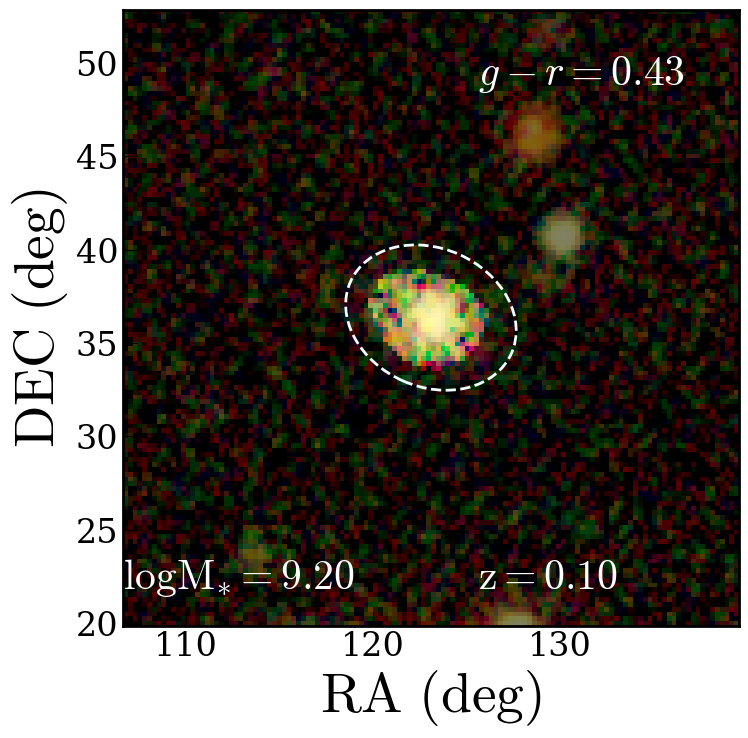

1222 [123.1422366  36.305268 ] 0.0837 8.556


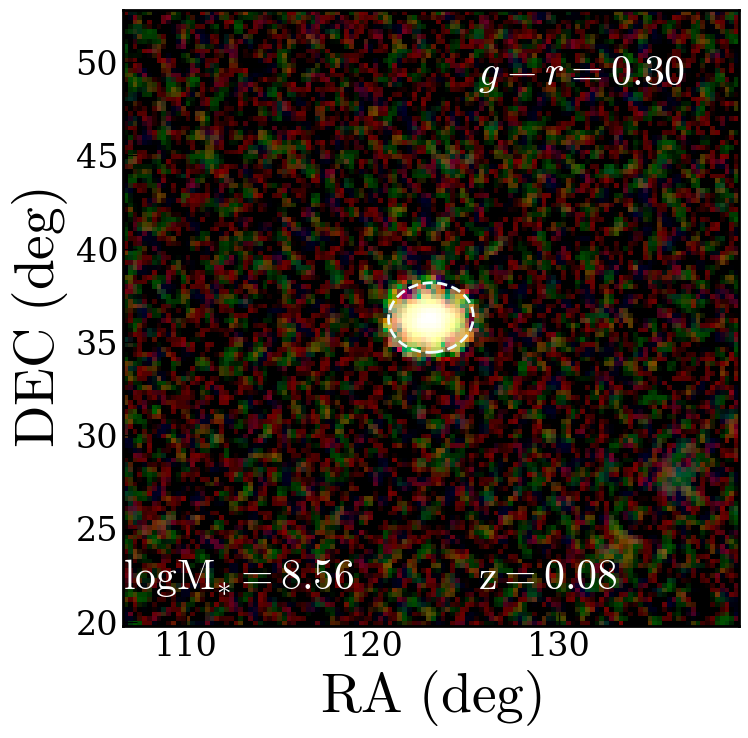

1223 [123.1437591  36.225173 ] 0.07548 9.402


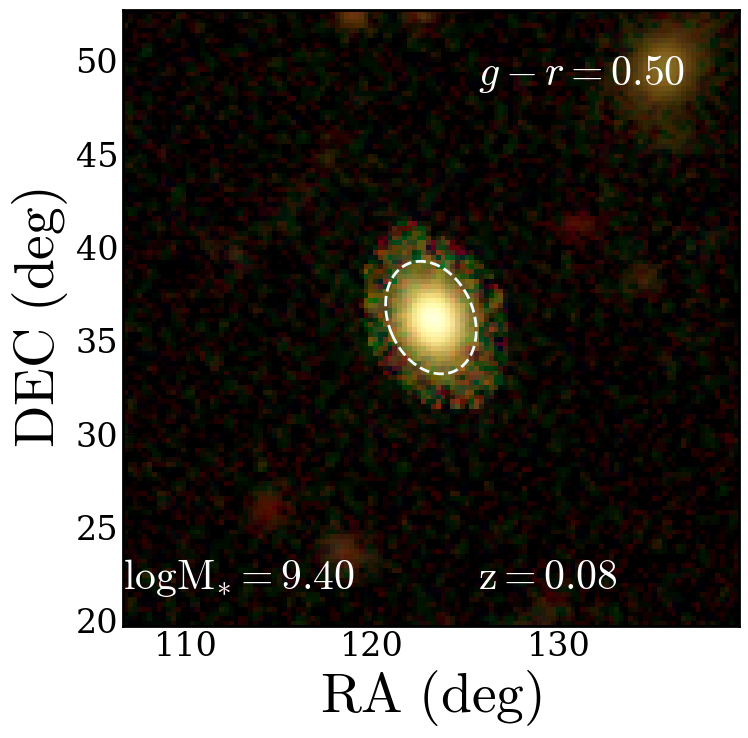

1224 [123.1541936  36.3136507] 0.0213 7.347


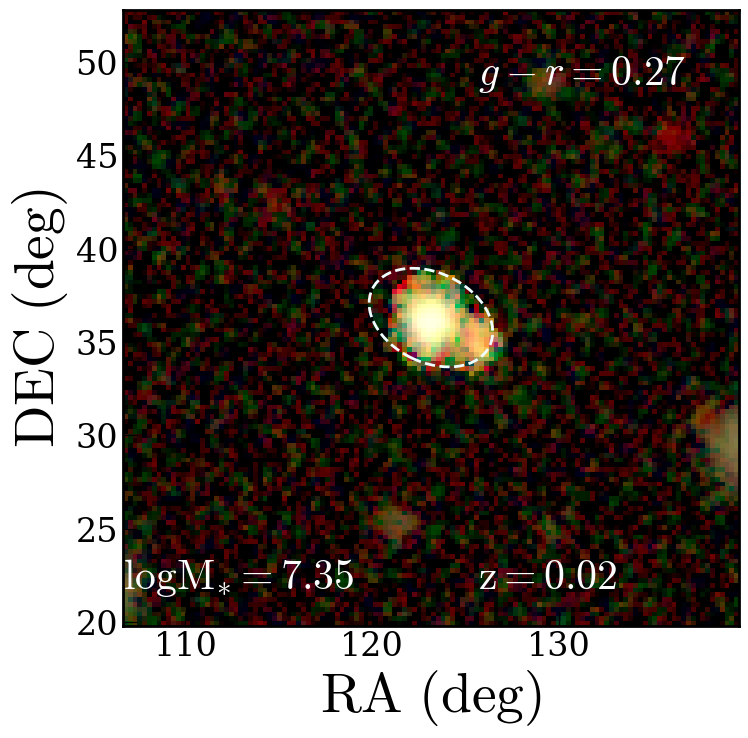

1225 [123.1597815  36.2846848] 0.0757 8.954


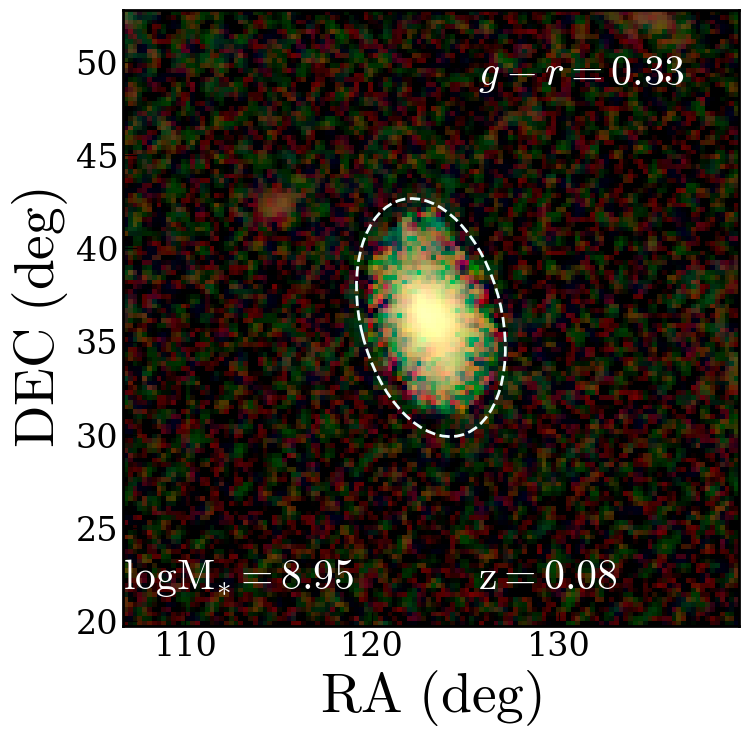

1226 [123.1933641  36.24608  ] 0.08353 8.703


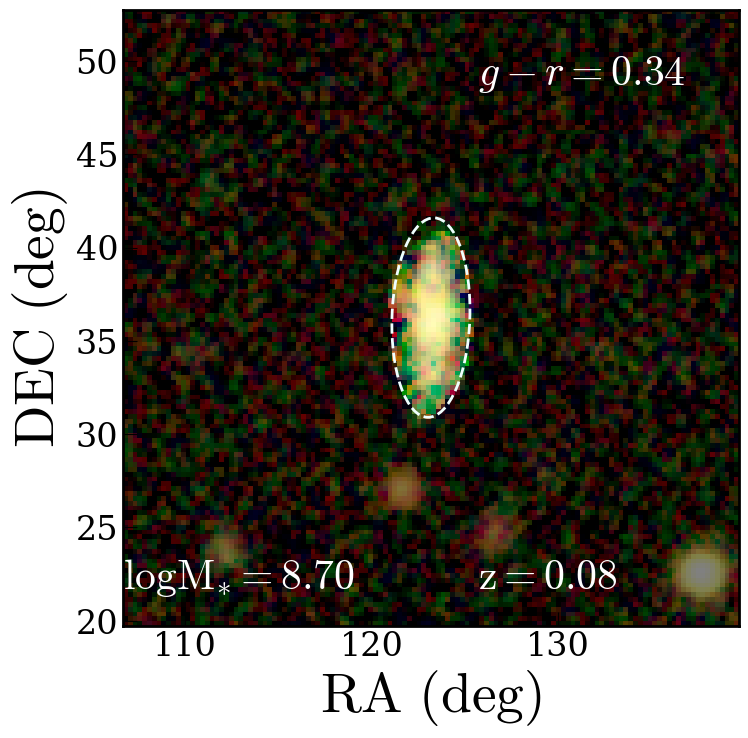

1227 [123.2068876  36.2015957] 0.07556 9.539


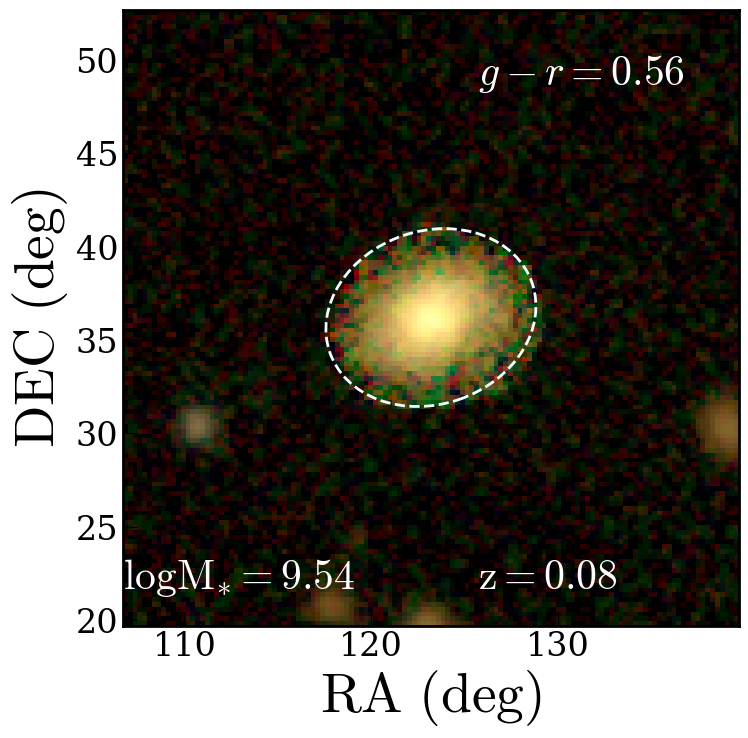

1228 [123.2139007  36.1721769] 0.0755 9.157


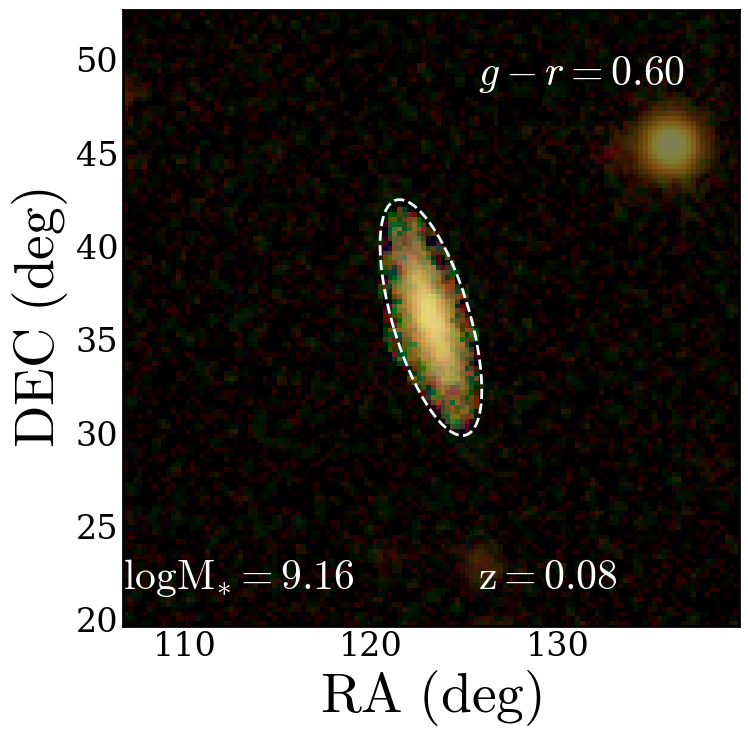

1229 [123.2967739  36.1678262] 0.0757 8.705
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.2968&dec=36.1678&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.2968_36.1678.fits


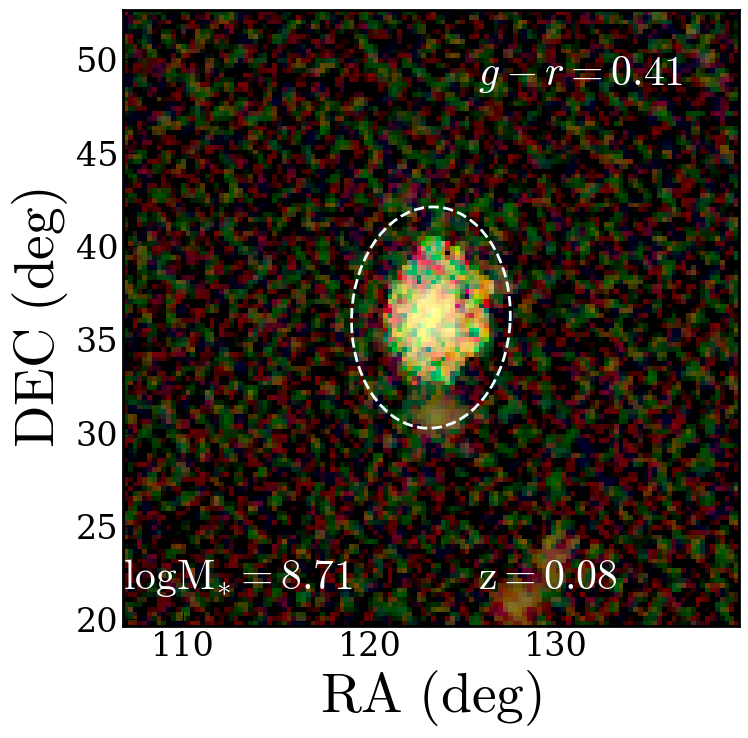

1230 [123.3153938  36.2723429] 0.08209 8.972
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.3154&dec=36.2723&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.3154_36.2723.fits


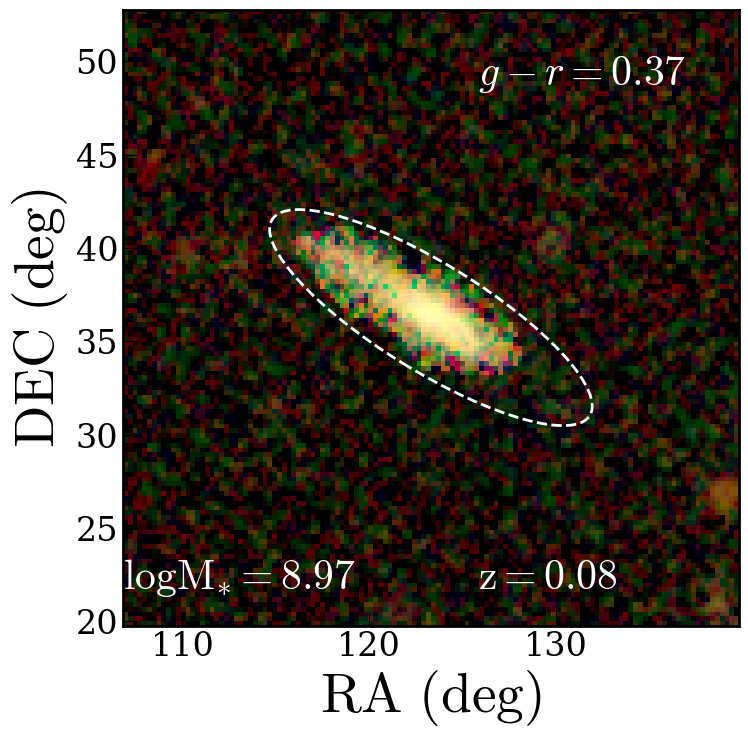

1231 [123.3836381  36.2900105] 0.02767 7.707
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.3836&dec=36.2900&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.3836_36.2900.fits


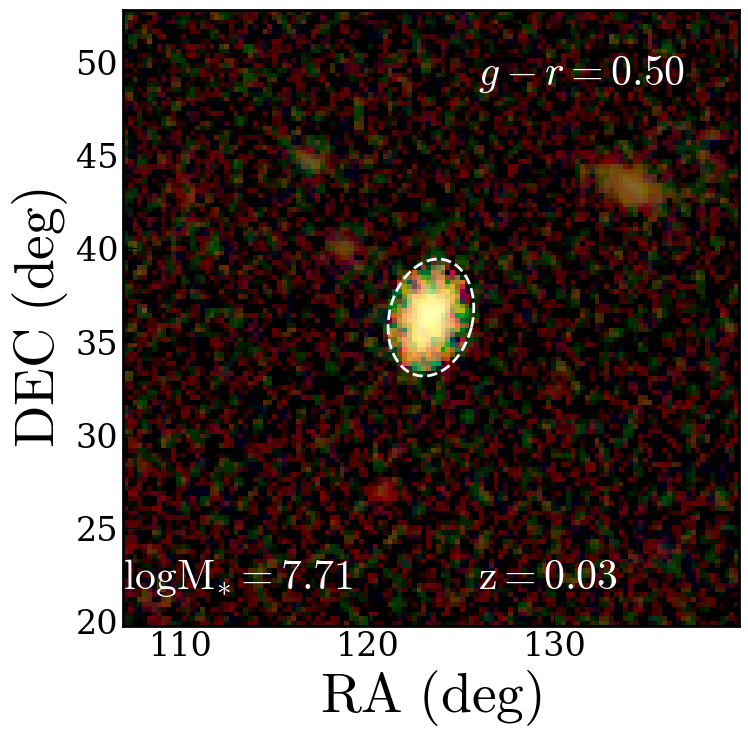

1232 [123.2681345  35.8024454] 0.08057 9.46
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.2681&dec=35.8024&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.2681_35.8024.fits


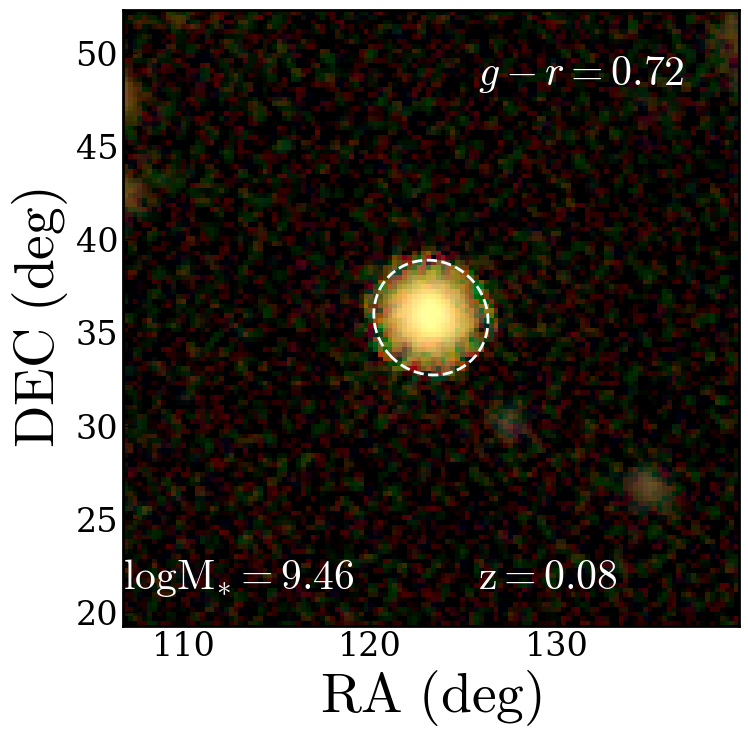

1233 [123.3953335  35.8418346] 0.04238 8.433
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.3953&dec=35.8418&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.3953_35.8418.fits


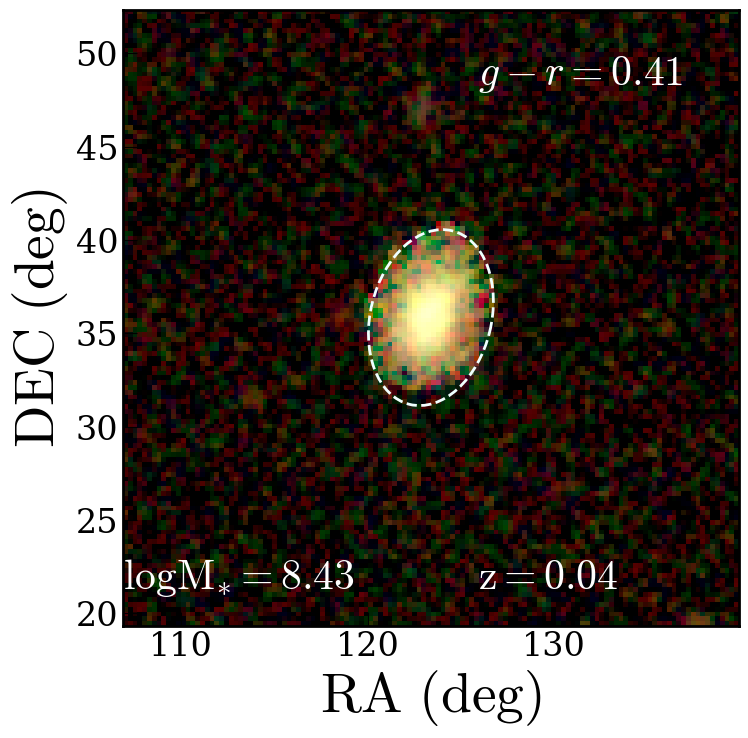

1234 [123.4140935  35.8465219] 0.04305 8.663
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.4141&dec=35.8465&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.4141_35.8465.fits


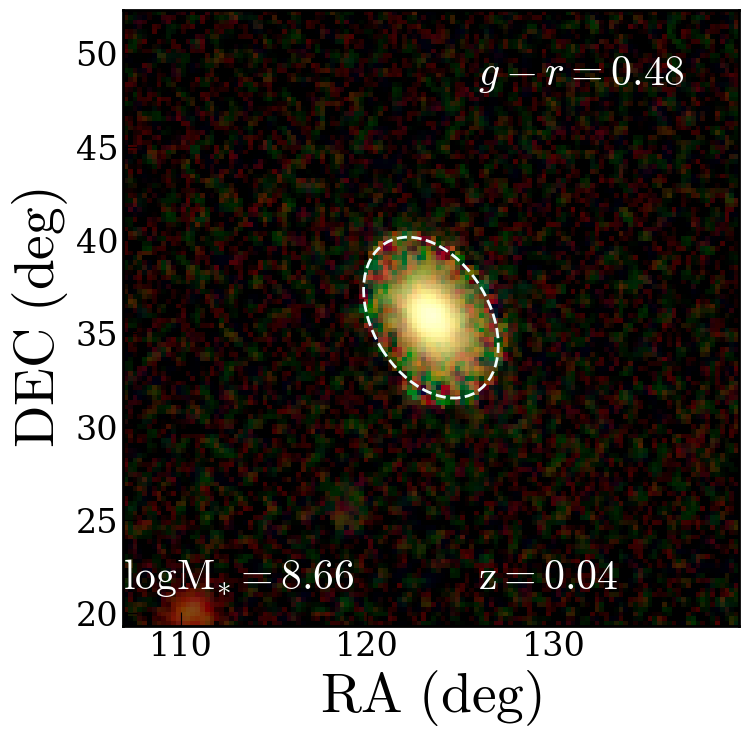

1235 [123.2367782  36.3756714] 0.05399 8.487
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.2368&dec=36.3757&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.2368_36.3757.fits


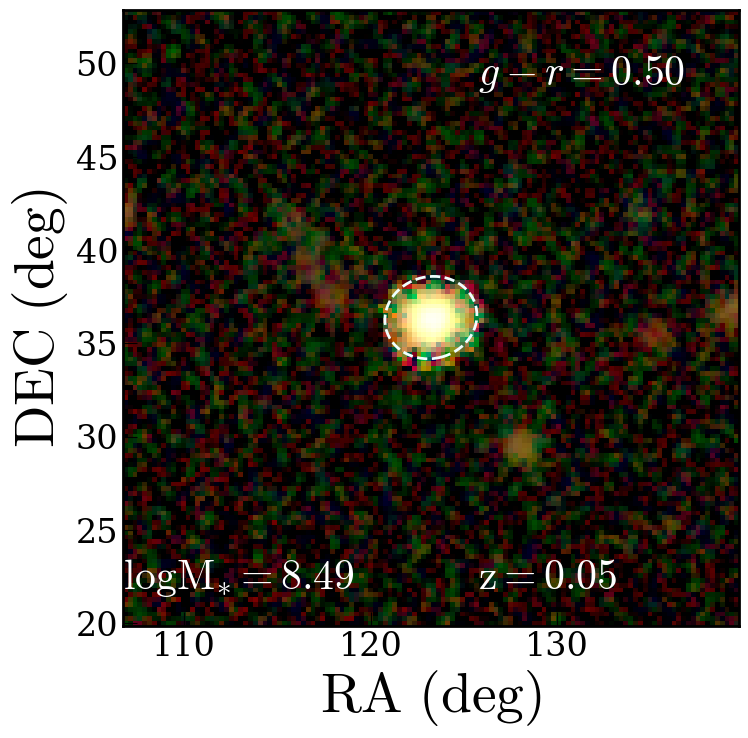

1236 [123.3029831  36.4920739] 0.08196 8.988
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.3030&dec=36.4921&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.3030_36.4921.fits


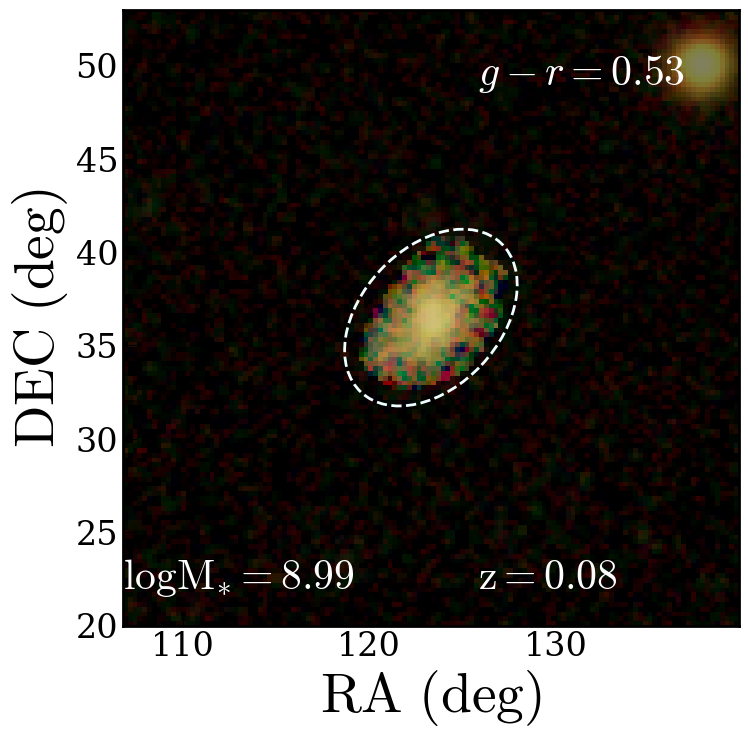

1237 [123.3138218  36.4502472] 0.08384 8.837
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.3138&dec=36.4502&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.3138_36.4502.fits


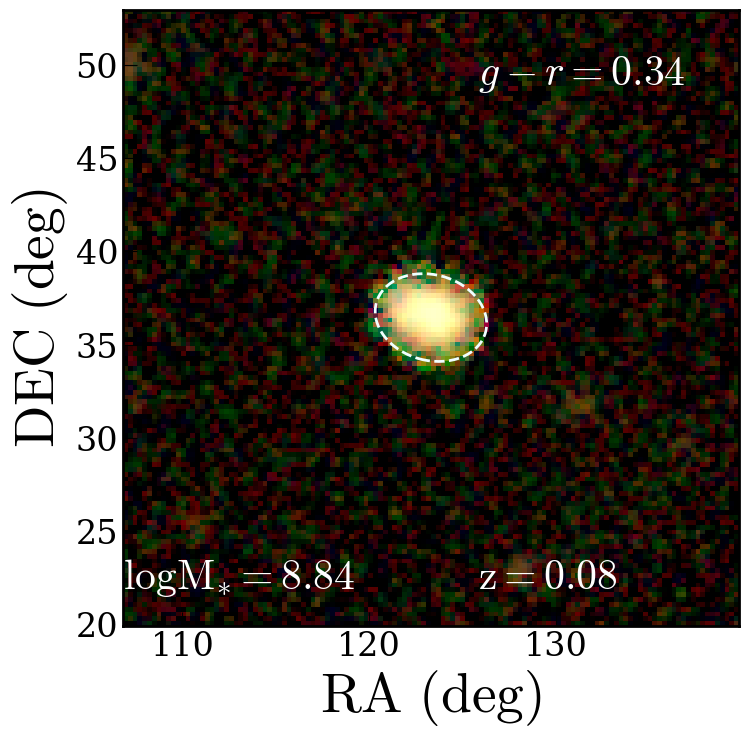

1238 [123.3855819  36.6028979] 0.02925 8.251
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.3856&dec=36.6029&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.3856_36.6029.fits


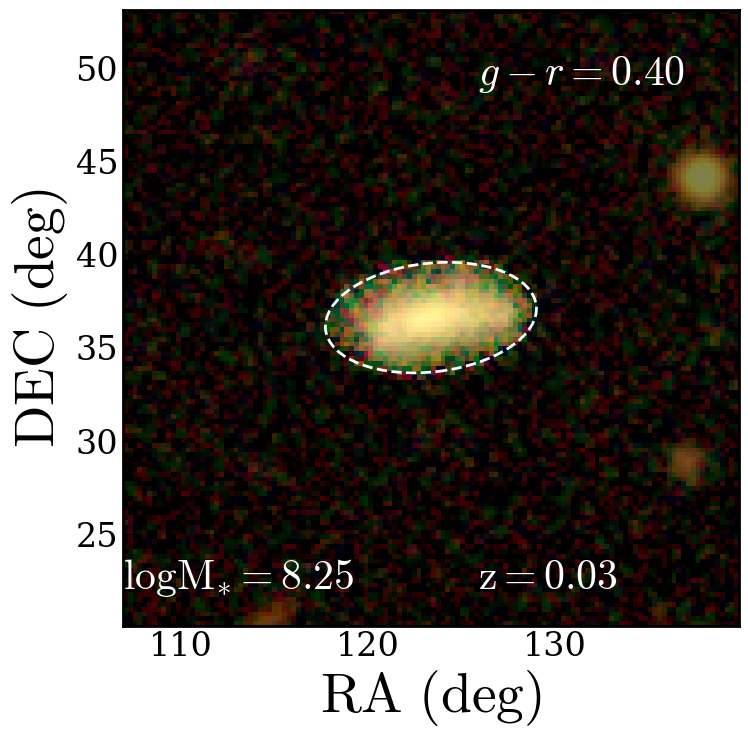

1239 [123.4332077  36.4439588] 0.08331 8.907
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.4332&dec=36.4440&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.4332_36.4440.fits


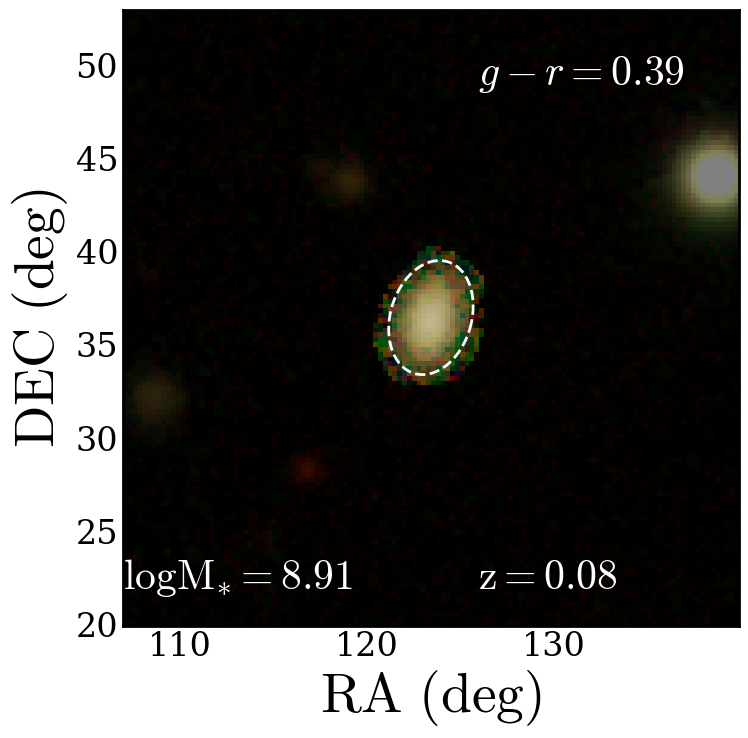

1240 [123.4709114  36.3783773] 0.08146 9.059
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.4709&dec=36.3784&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.4709_36.3784.fits


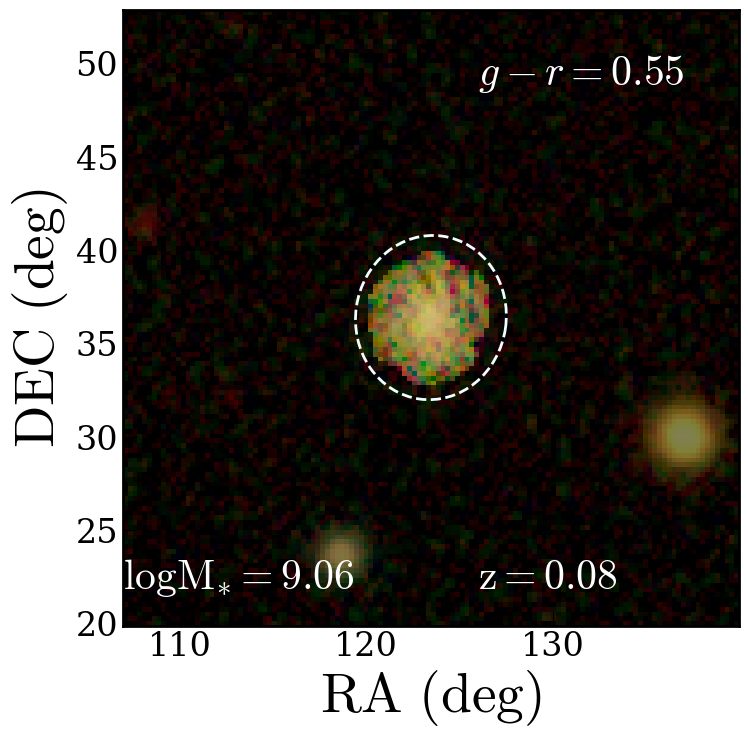

1241 [123.5142382  36.4587388] 0.07362 9.428
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.5142&dec=36.4587&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.5142_36.4587.fits


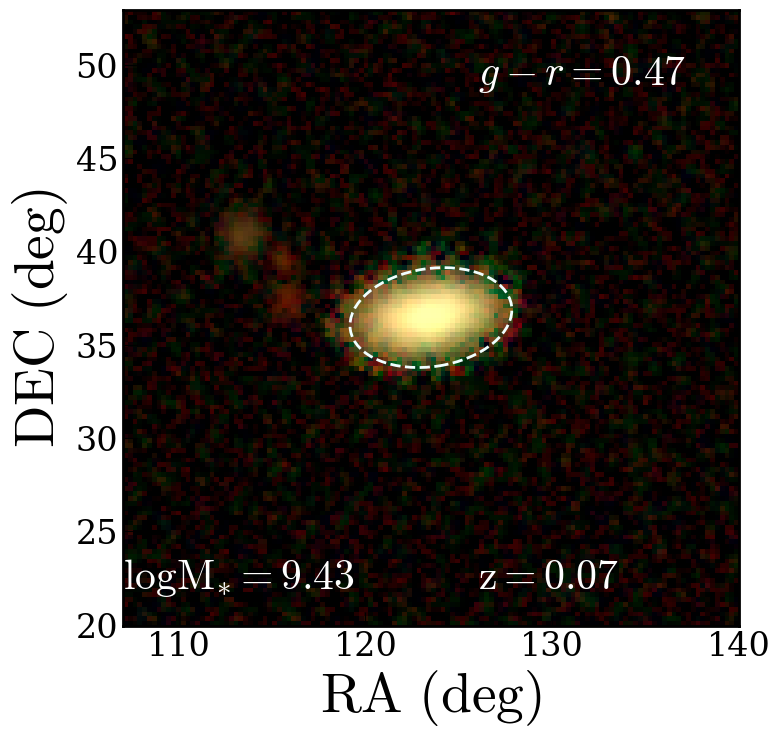

1242 [123.3616876  35.9917192] 0.02102 8.009
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.3617&dec=35.9917&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.3617_35.9917.fits


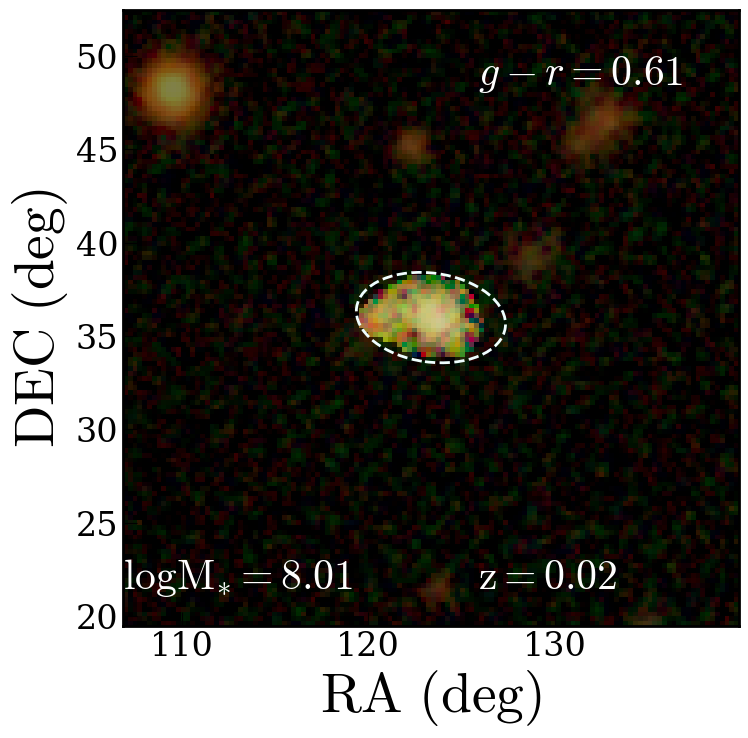

1243 [123.411321   36.0675552] 0.06076 8.72
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.4113&dec=36.0676&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.4113_36.0676.fits


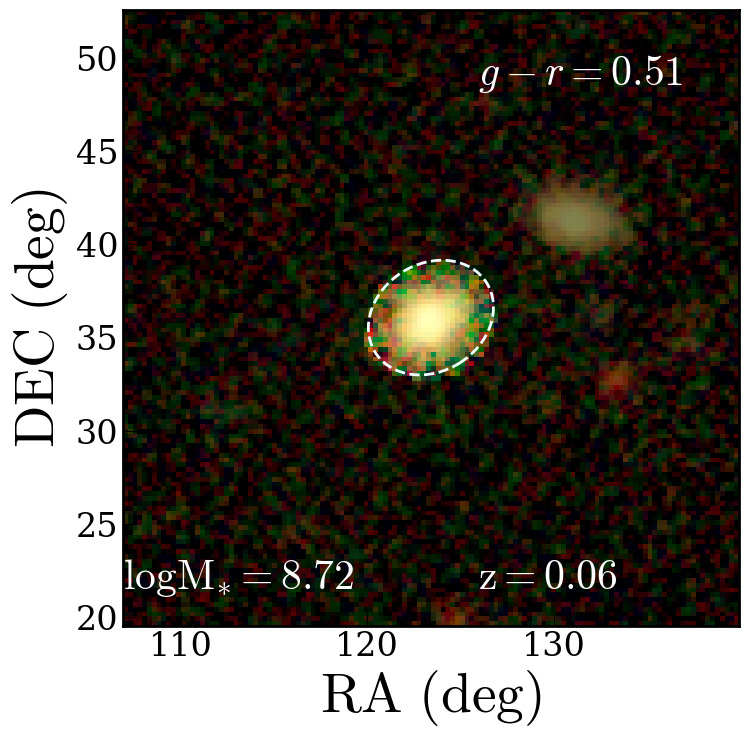

1244 [123.4282836  35.9972109] 0.07402 8.953
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.4283&dec=35.9972&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.4283_35.9972.fits


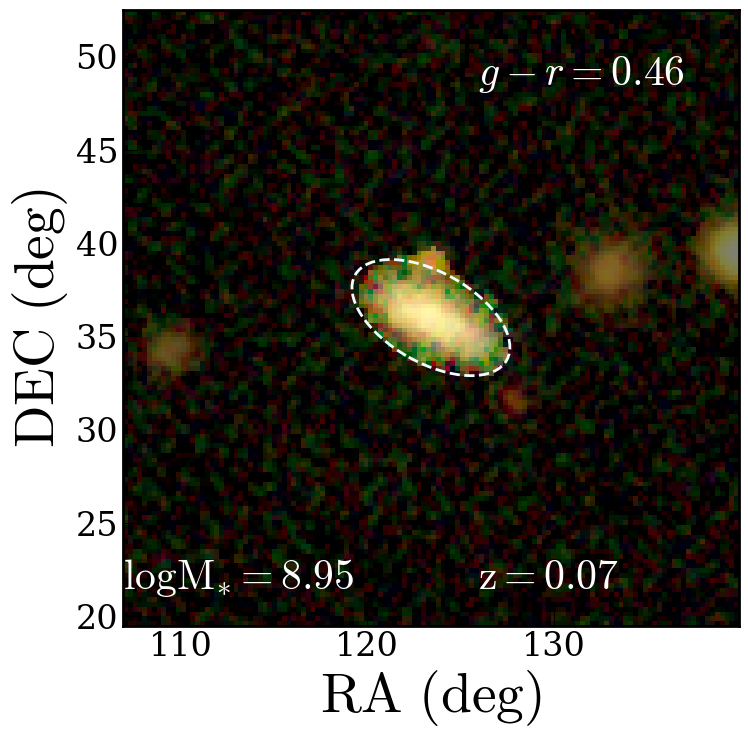

1245 [123.4566648  36.02416  ] 0.09853 9.303
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.4567&dec=36.0242&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.4567_36.0242.fits


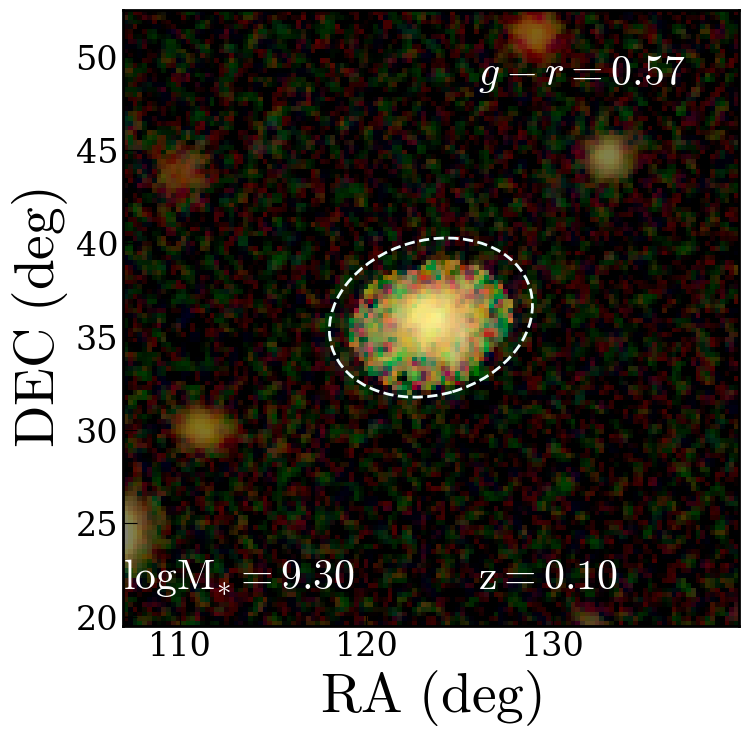

1246 [123.5175872  35.9753776] 0.08315 9.615
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.5176&dec=35.9754&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.5176_35.9754.fits


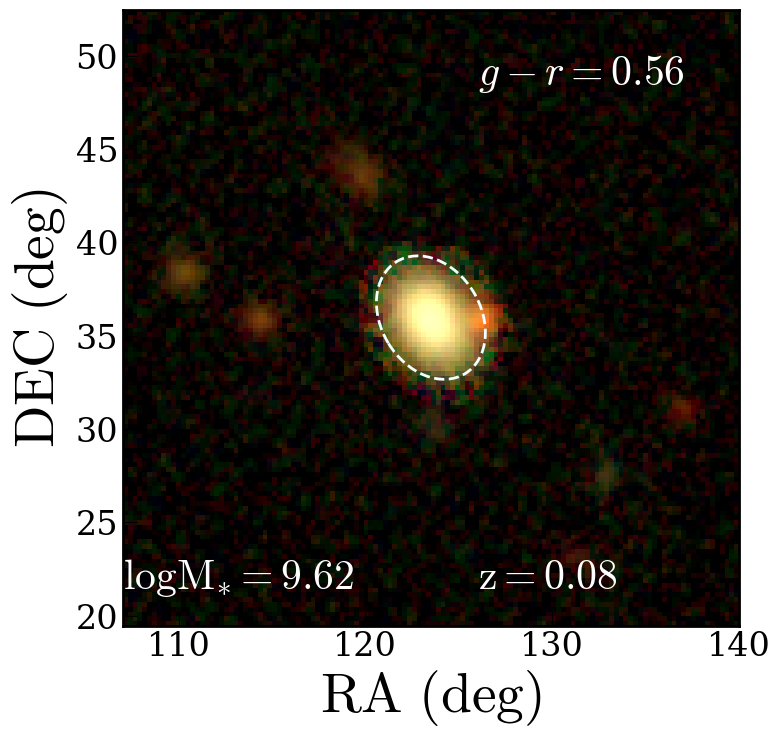

1247 [123.594173   36.0612768] 0.07387 8.491
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.5942&dec=36.0613&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.5942_36.0613.fits


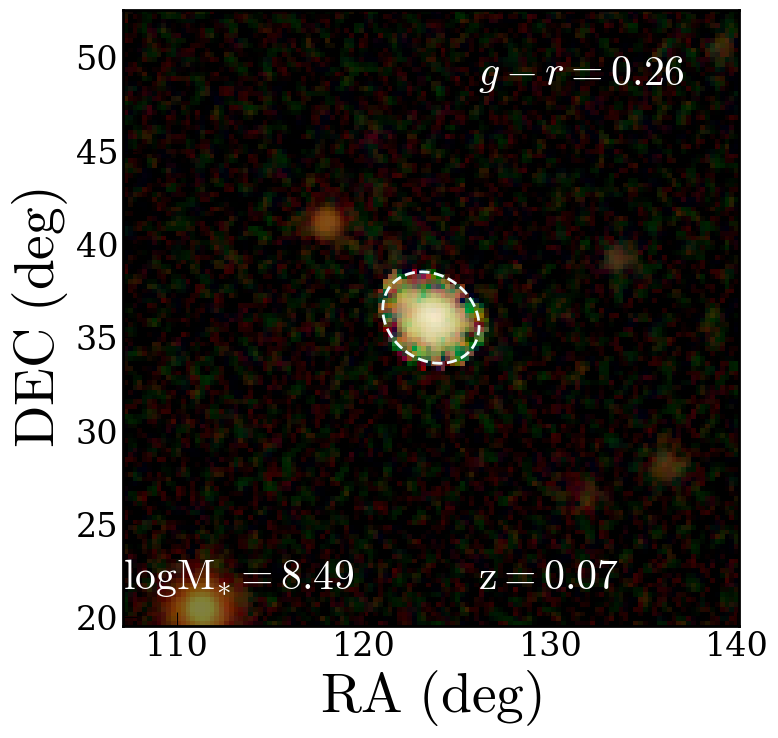

1248 [123.4689236  36.6522964] 0.08226 9.915
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.4689&dec=36.6523&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.4689_36.6523.fits


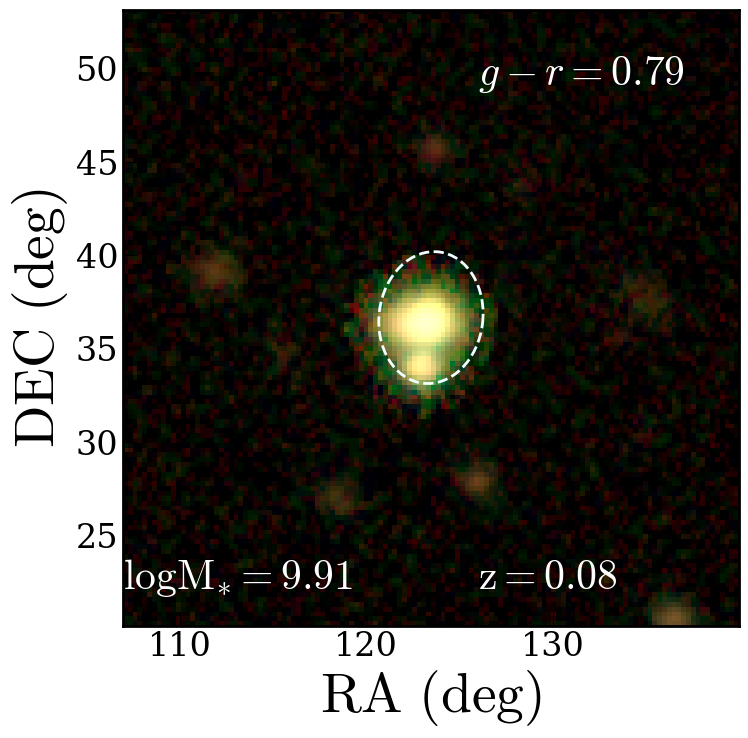

1249 [123.4034035  36.3068166] 0.08336 9.856
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.4034&dec=36.3068&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.4034_36.3068.fits


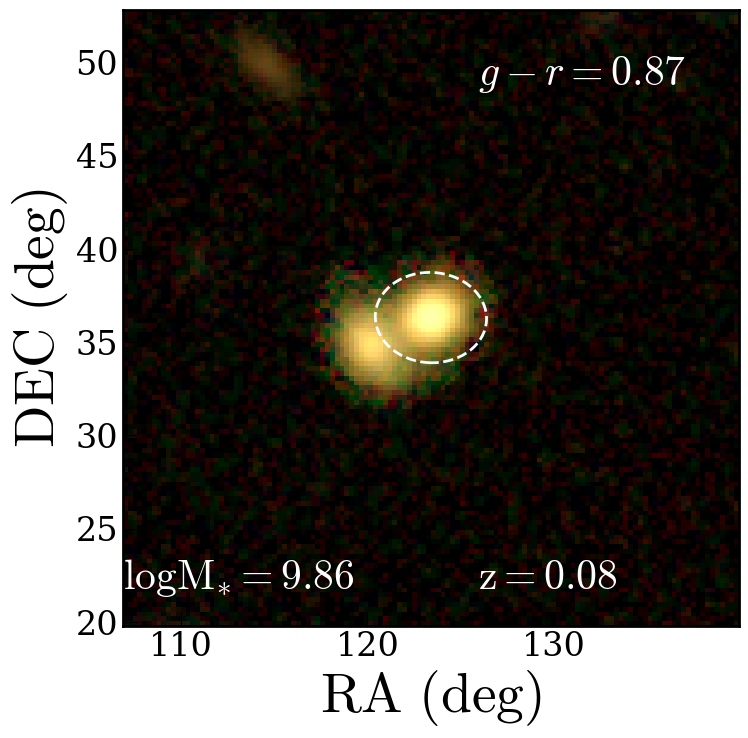

1250 [123.4200826  36.2551214] 0.02768 8.361
https://www.legacysurvey.org/viewer/fits-cutout?ra=123.4201&dec=36.2551&size=128&layer=ls-dr9-north&invvar&pixscale=0.262&bands=grz
downloading --  cutout_123.4201_36.2551.fits


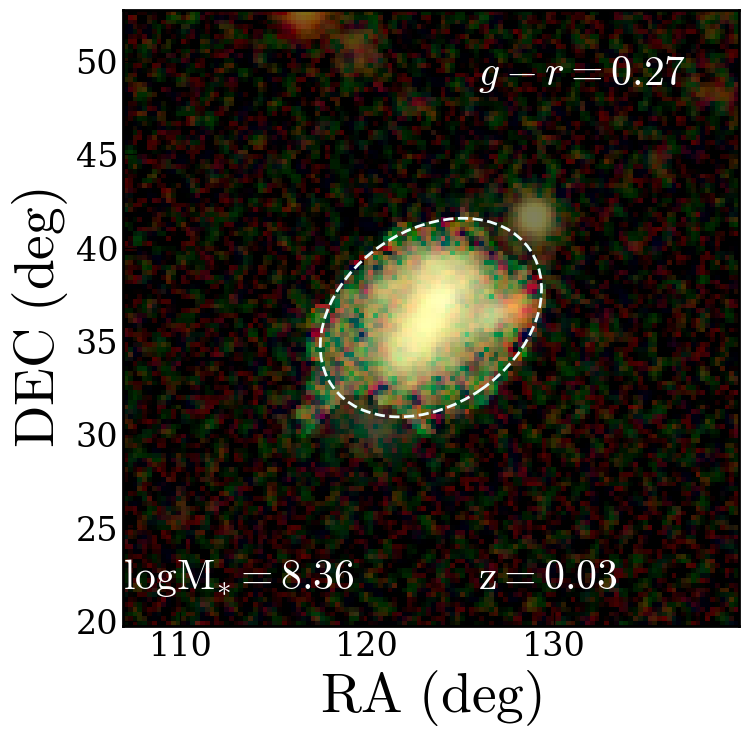

(51, 77)
106.77016305923462


In [20]:
morph_all = []
model_psf = psf_grid(d_psf=8,fwhm=3)
imzer = np.zeros((npix,npix))
xx, yy = np.meshgrid(np.arange(0,npix,1),np.arange(0,npix,1))
#r_list = ptf.make_radius_list(max_pix=50,n=50)

t1 = time.time()

for ii,key in sources.iterrows():
        if ii<1200 or ii>1250: continue
        pos = np.array([key['ra'],key['dec']])
        print(ii,pos,key['zspec'],key['logM'])
        
        download_cutout(pos.reshape(1,2))
        filename = 'cutout_{:.4f}_{:.4f}.fits'.format(pos[0],pos[1])
        #print(filename)
        try: data = fits.open("cutouts/"+filename)
        except: continue

        img_data,img_hdr,img_rms,glob_rms,flags = image_bkg(data)
        if (flags[0] or flags[1]): continue

        w = wcs.WCS(img_hdr,naxis=2)
        pos_coord = SkyCoord(ra=pos[0]*u.degree, dec=pos[1]*u.degree, frame='icrs')
        wc = [int(i) for i in w.world_to_pixel(pos_coord)]
        
        comp_segmap,comp_mask,flags = image_segmap(img_data,img_rms,model_psf,wc,flags)
        if (flags[0] or flags[1]): continue

        morph_arr = np.zeros((4,19))
        #ax.scatter(pos[0], pos[1],marker='*',color='red',s=40,zorder=101)
        for jj,k in enumerate(bands):
            if flags[jj]==True: continue
            obs_psf = psf_grid(d_psf=16,fwhm=key['psfsize_'+k]/pixsc,psf_type='moffat')
            morph = statmorph.source_morphology(img_data[jj], comp_segmap, weightmap=img_rms[jj],mask=comp_mask.astype('bool'),psf=obs_psf)[0]

            morph_arr[jj,:8] = [morph.gini,morph.m20,morph.concentration,morph.asymmetry,morph.smoothness,morph.shape_asymmetry,morph.flag,morph.sn_per_pixel]

            morph_arr[jj,8] = morph.r20/(key['psfsize_'+k]/pixsc)
            zz = elliptical_transform(xx-morph.xc_asymmetry,yy-morph.yc_asymmetry,morph.rpetro_ellip,morph.orientation_asymmetry,morph.ellipticity_asymmetry)
            morph_arr[jj,9] = np.sum(1*((comp_segmap>0)))/np.sum(1*(zz<1))
            morph_arr[jj,10:15] = [morph.xc_asymmetry,morph.yc_asymmetry,morph.rpetro_ellip,morph.orientation_asymmetry,morph.ellipticity_asymmetry]

            morph_arr[jj,15:] = [morph.sersic_n,morph.sersic_rhalf,morph.sersic_ellip,morph.flag_sersic]

            '''
                prior  = autoprior(image = img_data[jj], profile_type = 'sersic', mask=mask, sky_type = 'flat') 
                fitter = FitSingle(data=img_data[jj],rms=img_rms[jj],mask=mask,psf=obs_psf,prior=prior,loss_func=student_t_loss)
                map_params = fitter.find_MAP(rkey = PRNGKey(1000))
            '''
        plot_cutout(img_data,comp_segmap,pos,w,morph_arr[0,10:15],key)

        morph_row = [ii]
        morph_row.extend(morph_arr.ravel())
        morph_all.append(morph_row)

print(np.shape(morph_all))
t2= time.time()
print(t2-t1)

In [21]:
param_names = ['gini','m20','c','a','s','a_s','flag','snr_pix','r20_psf','segm_petr','xc_as','yc_as','rpetro','orien_as','ellip_as','n','rhalf','ellip_ss','flag_ss']
col_names = ['ind']
for b in bands: col_names.extend([x+'_'+b for x in param_names])
print(len(col_names))

df = pd.DataFrame(morph_all, columns=col_names)
df.to_csv('saga_morph.csv', index=False)

77


In [22]:
smorph = pd.read_csv('saga_morph.csv')

print(smorph.columns)
print(smorph.shape)

Index(['ind', 'gini_g', 'm20_g', 'c_g', 'a_g', 's_g', 'a_s_g', 'flag_g',
       'snr_pix_g', 'r20_psf_g', 'segm_petr_g', 'xc_as_g', 'yc_as_g',
       'rpetro_g', 'orien_as_g', 'ellip_as_g', 'n_g', 'rhalf_g', 'ellip_ss_g',
       'flag_ss_g', 'gini_r', 'm20_r', 'c_r', 'a_r', 's_r', 'a_s_r', 'flag_r',
       'snr_pix_r', 'r20_psf_r', 'segm_petr_r', 'xc_as_r', 'yc_as_r',
       'rpetro_r', 'orien_as_r', 'ellip_as_r', 'n_r', 'rhalf_r', 'ellip_ss_r',
       'flag_ss_r', 'gini_i', 'm20_i', 'c_i', 'a_i', 's_i', 'a_s_i', 'flag_i',
       'snr_pix_i', 'r20_psf_i', 'segm_petr_i', 'xc_as_i', 'yc_as_i',
       'rpetro_i', 'orien_as_i', 'ellip_as_i', 'n_i', 'rhalf_i', 'ellip_ss_i',
       'flag_ss_i', 'gini_z', 'm20_z', 'c_z', 'a_z', 's_z', 'a_s_z', 'flag_z',
       'snr_pix_z', 'r20_psf_z', 'segm_petr_z', 'xc_as_z', 'yc_as_z',
       'rpetro_z', 'orien_as_z', 'ellip_as_z', 'n_z', 'rhalf_z', 'ellip_ss_z',
       'flag_ss_z'],
      dtype='object')
(51, 77)


49
46
0
38


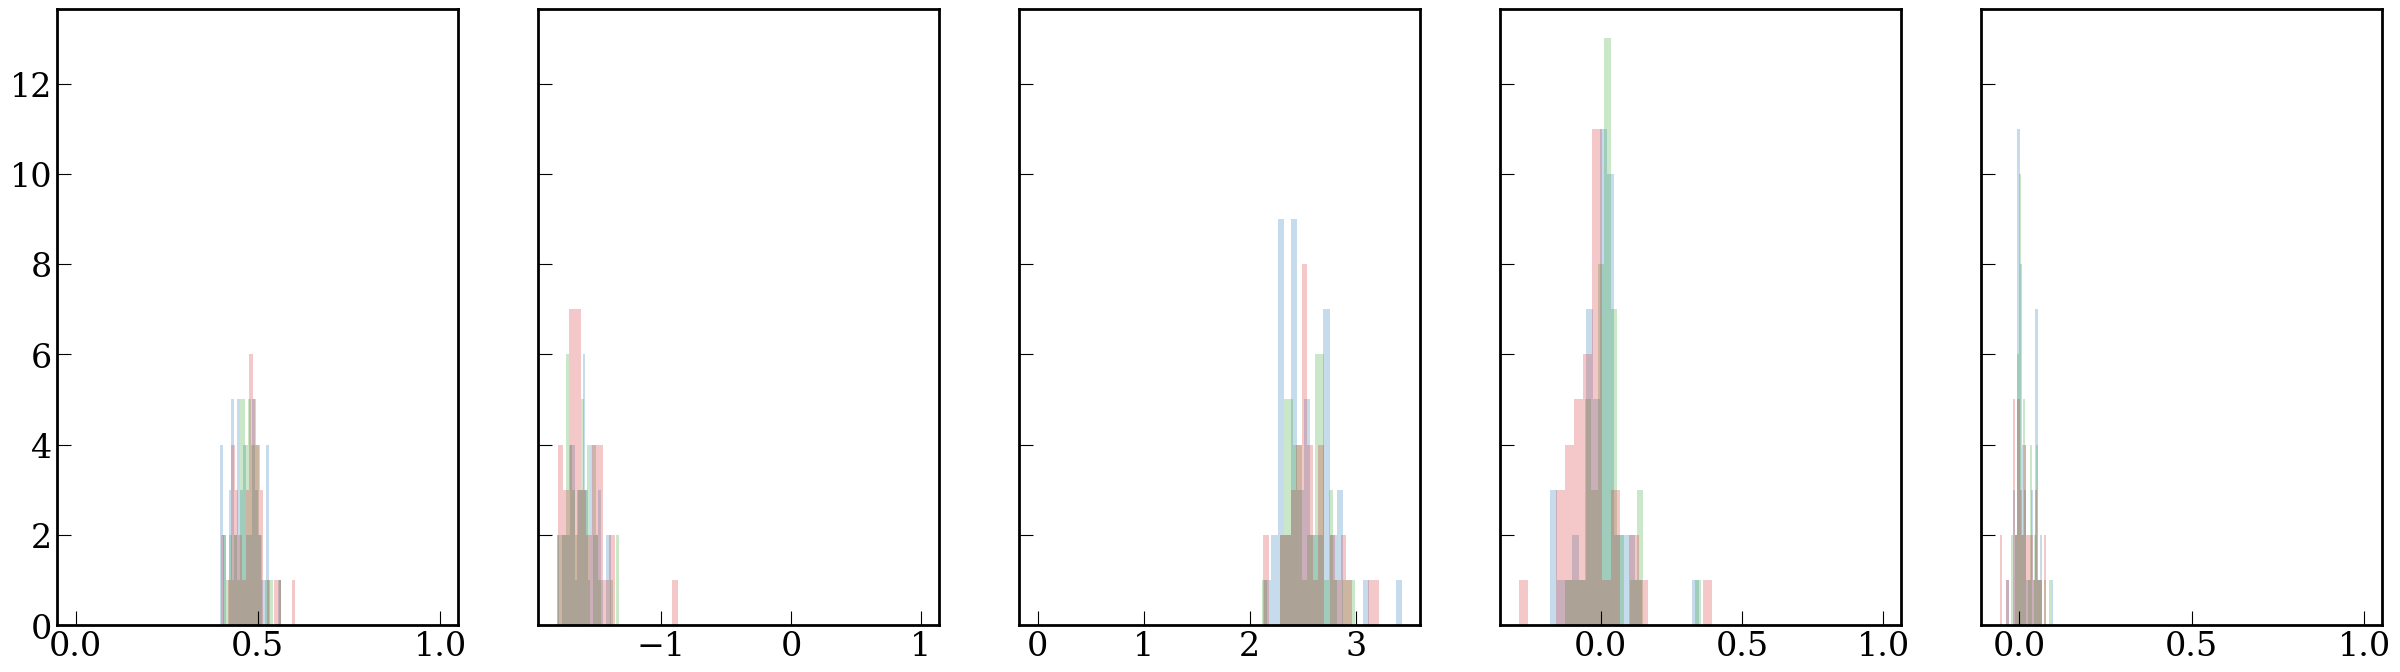

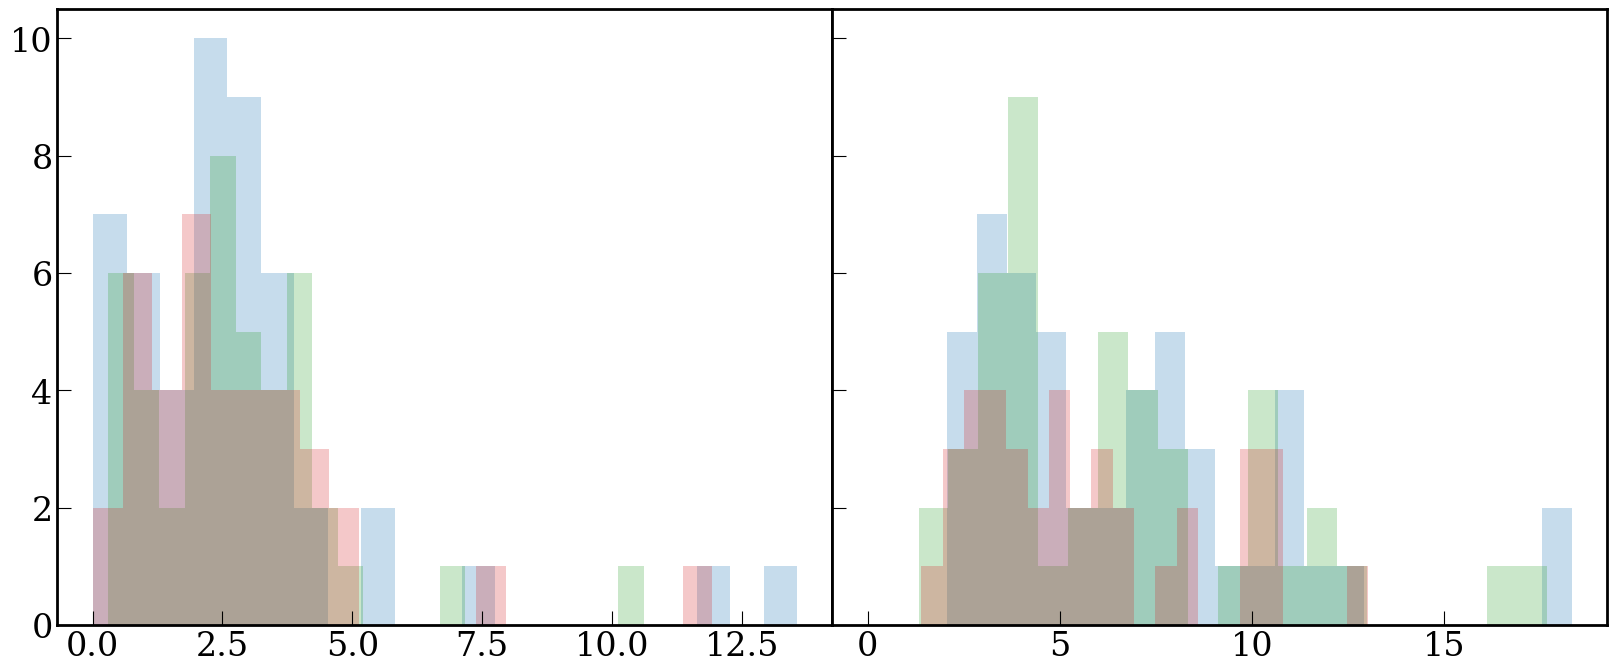

In [23]:
fig,ax=plt.subplots(1,5,figsize=(30,8),sharey=True)
fig1,ax1=plt.subplots(1,2,figsize=(20,8),sharey=True)
param_names = ['gini','m20','c','a','s','a_s','flag','snr_pix','r20_psf','segm_petr','xc_as','yc_as','rpetro','orien_as','ellip_as','n','rhalf','ellip_ss','flag_ss']

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i,key in enumerate(bands):
    high_snr = np.where((smorph['snr_pix_'+key]>2)&(smorph['flag_'+key]<=1))[0]
    print(len(high_snr))

    for j in range(5):
        ax[j].hist(smorph[param_names[j]+'_'+key][high_snr],bins=21,alpha=0.25,color=griz_col[i])
    for j in range(2):
        ax1[j].hist(smorph[param_names[15+j]+'_'+key][high_snr],bins=21,alpha=0.25,color=griz_col[i])
        
plt.subplots_adjust(wspace=0.0)




47 47
47 47
47 47
47 47


<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
/var/folders/_b/znph9d951ln009y69l1s4tn00000gn/T/ipykernel_57074/3978245827.py:25: SyntaxWarning: invalid escape sequence '\i'
  ax[0].set_xlabel(r'${\it Gini}$',fontsize=36)


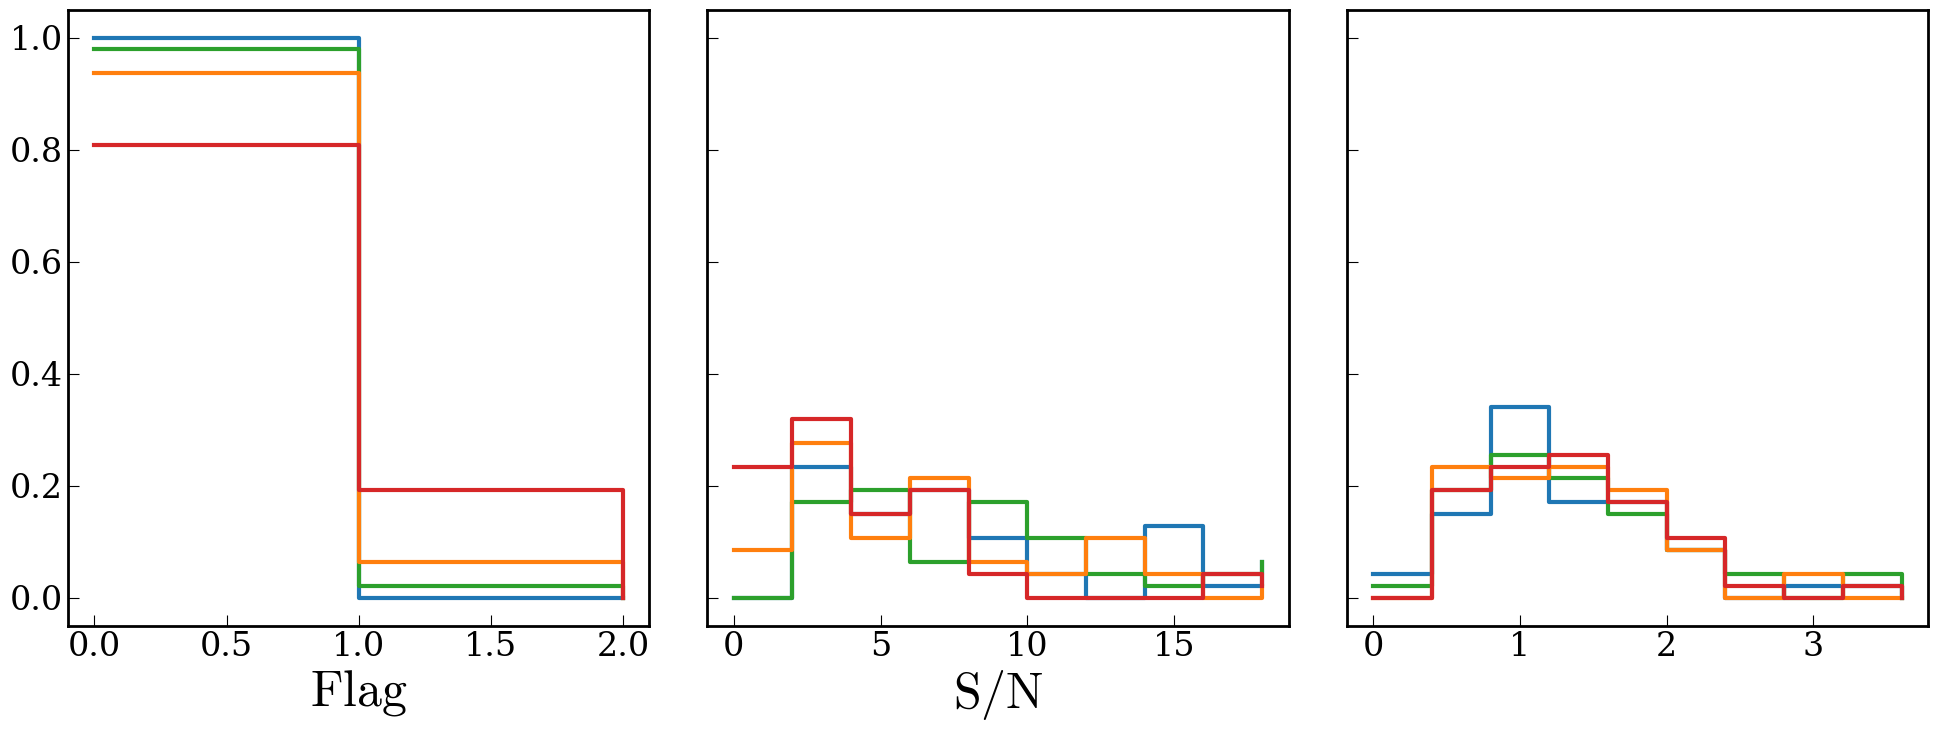

In [25]:
fig,ax=plt.subplots(1,3,figsize=(24,8),sharey='row')

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i in range(4):
    print(len(morph_all[:,i,9]),len(morph_all[:,i,10]))
    #print(morph_arr[:,-1])
    hist, bin_edg = np.histogram(morph_all[:,i,9], bins=np.arange(0,4,1))
    
    ax[0].step(bin_edg[:-1],hist/len(morph_all[:,i,9]),where='post',lw=3,color=griz_col[i])

    hist, bin_edg = np.histogram(morph_all[:,i,10], bins=np.linspace(0,20,11))
    
    ax[1].step(bin_edg[:-1],hist/len(morph_all[:,i,10]),where='post',lw=3,color=griz_col[i])
    #ax[i,2].hist(morph_all[:,i,10],bins=np.linspace(0,1,26),alpha=0.4,color=griz_col[i])

    hist, bin_edg = np.histogram(morph_all[:,i,11], bins=np.linspace(0,4,11))
    
    ax[2].step(bin_edg[:-1],hist/len(morph_all[:,i,11]),where='post',lw=3,color=griz_col[i])

ax[0].set_xlabel(r'${Flag}$',fontsize=36)
ax[1].set_xlabel(r'$S/N$',fontsize=36)
#ax[3,2].set_xlabel(r'$Segm\ Frac$',fontsize=36)
'''
ax[0].set_xlabel(r'${\it Gini}$',fontsize=36)
ax[1].set_xlabel(r'$M_{20}$',fontsize=36)
ax[2].set_xlabel(r'$Concentration$',fontsize=36)
ax[3].set_xlabel(r'$Asymmetry$',fontsize=36)
ax[4].set_xlabel(r'$Smoothness$',fontsize=36)
'''
plt.subplots_adjust(hspace=0.0,wspace=0.1)
#plt.savefig('NPdistributions.pdf',bbox_inches='tight')

3243 [187.3702767  -2.0083458] 0.0829 9.431
g Background: 9.10700618987903e-05 g RMS^2: 1.5337418237793525e-06 g Var: 2.0148636e-06
r Background: 0.000367378699593246 r RMS^2: 1.7430398585116004e-05 r Var: 2.3255037e-05
i Background: 0.0008572903461754322 i RMS^2: 8.31495080459016e-05 i Var: 0.000111852336
z Background: 0.000441000796854496 z RMS^2: 9.21819326478307e-05 z Var: 0.00013463297
4473 [218.9849391   2.0838757] 0.09376 8.405
g Background: 9.120311005972326e-05 g RMS^2: 1.0981850616551773e-06 g Var: 1.2605151e-06
r Background: 0.0001902790681924671 r RMS^2: 3.7619419743402925e-06 r Var: 4.0683926e-06
i Background: 0.0003786060551647097 i RMS^2: 5.4023233722555464e-05 i Var: 6.5964006e-05
z Background: 9.39509118325077e-05 z RMS^2: 2.656673664426512e-05 z Var: 3.1624622e-05
4941 [321.3263601 -45.6765114] 0.07526 8.809
g Background: 1.3998112990520895e-05 g RMS^2: 1.6834355196518e-06 g Var: 2.6878174e-06
r Background: 7.284658931894228e-05 r RMS^2: 3.181516612795832e-06 r Var: 4

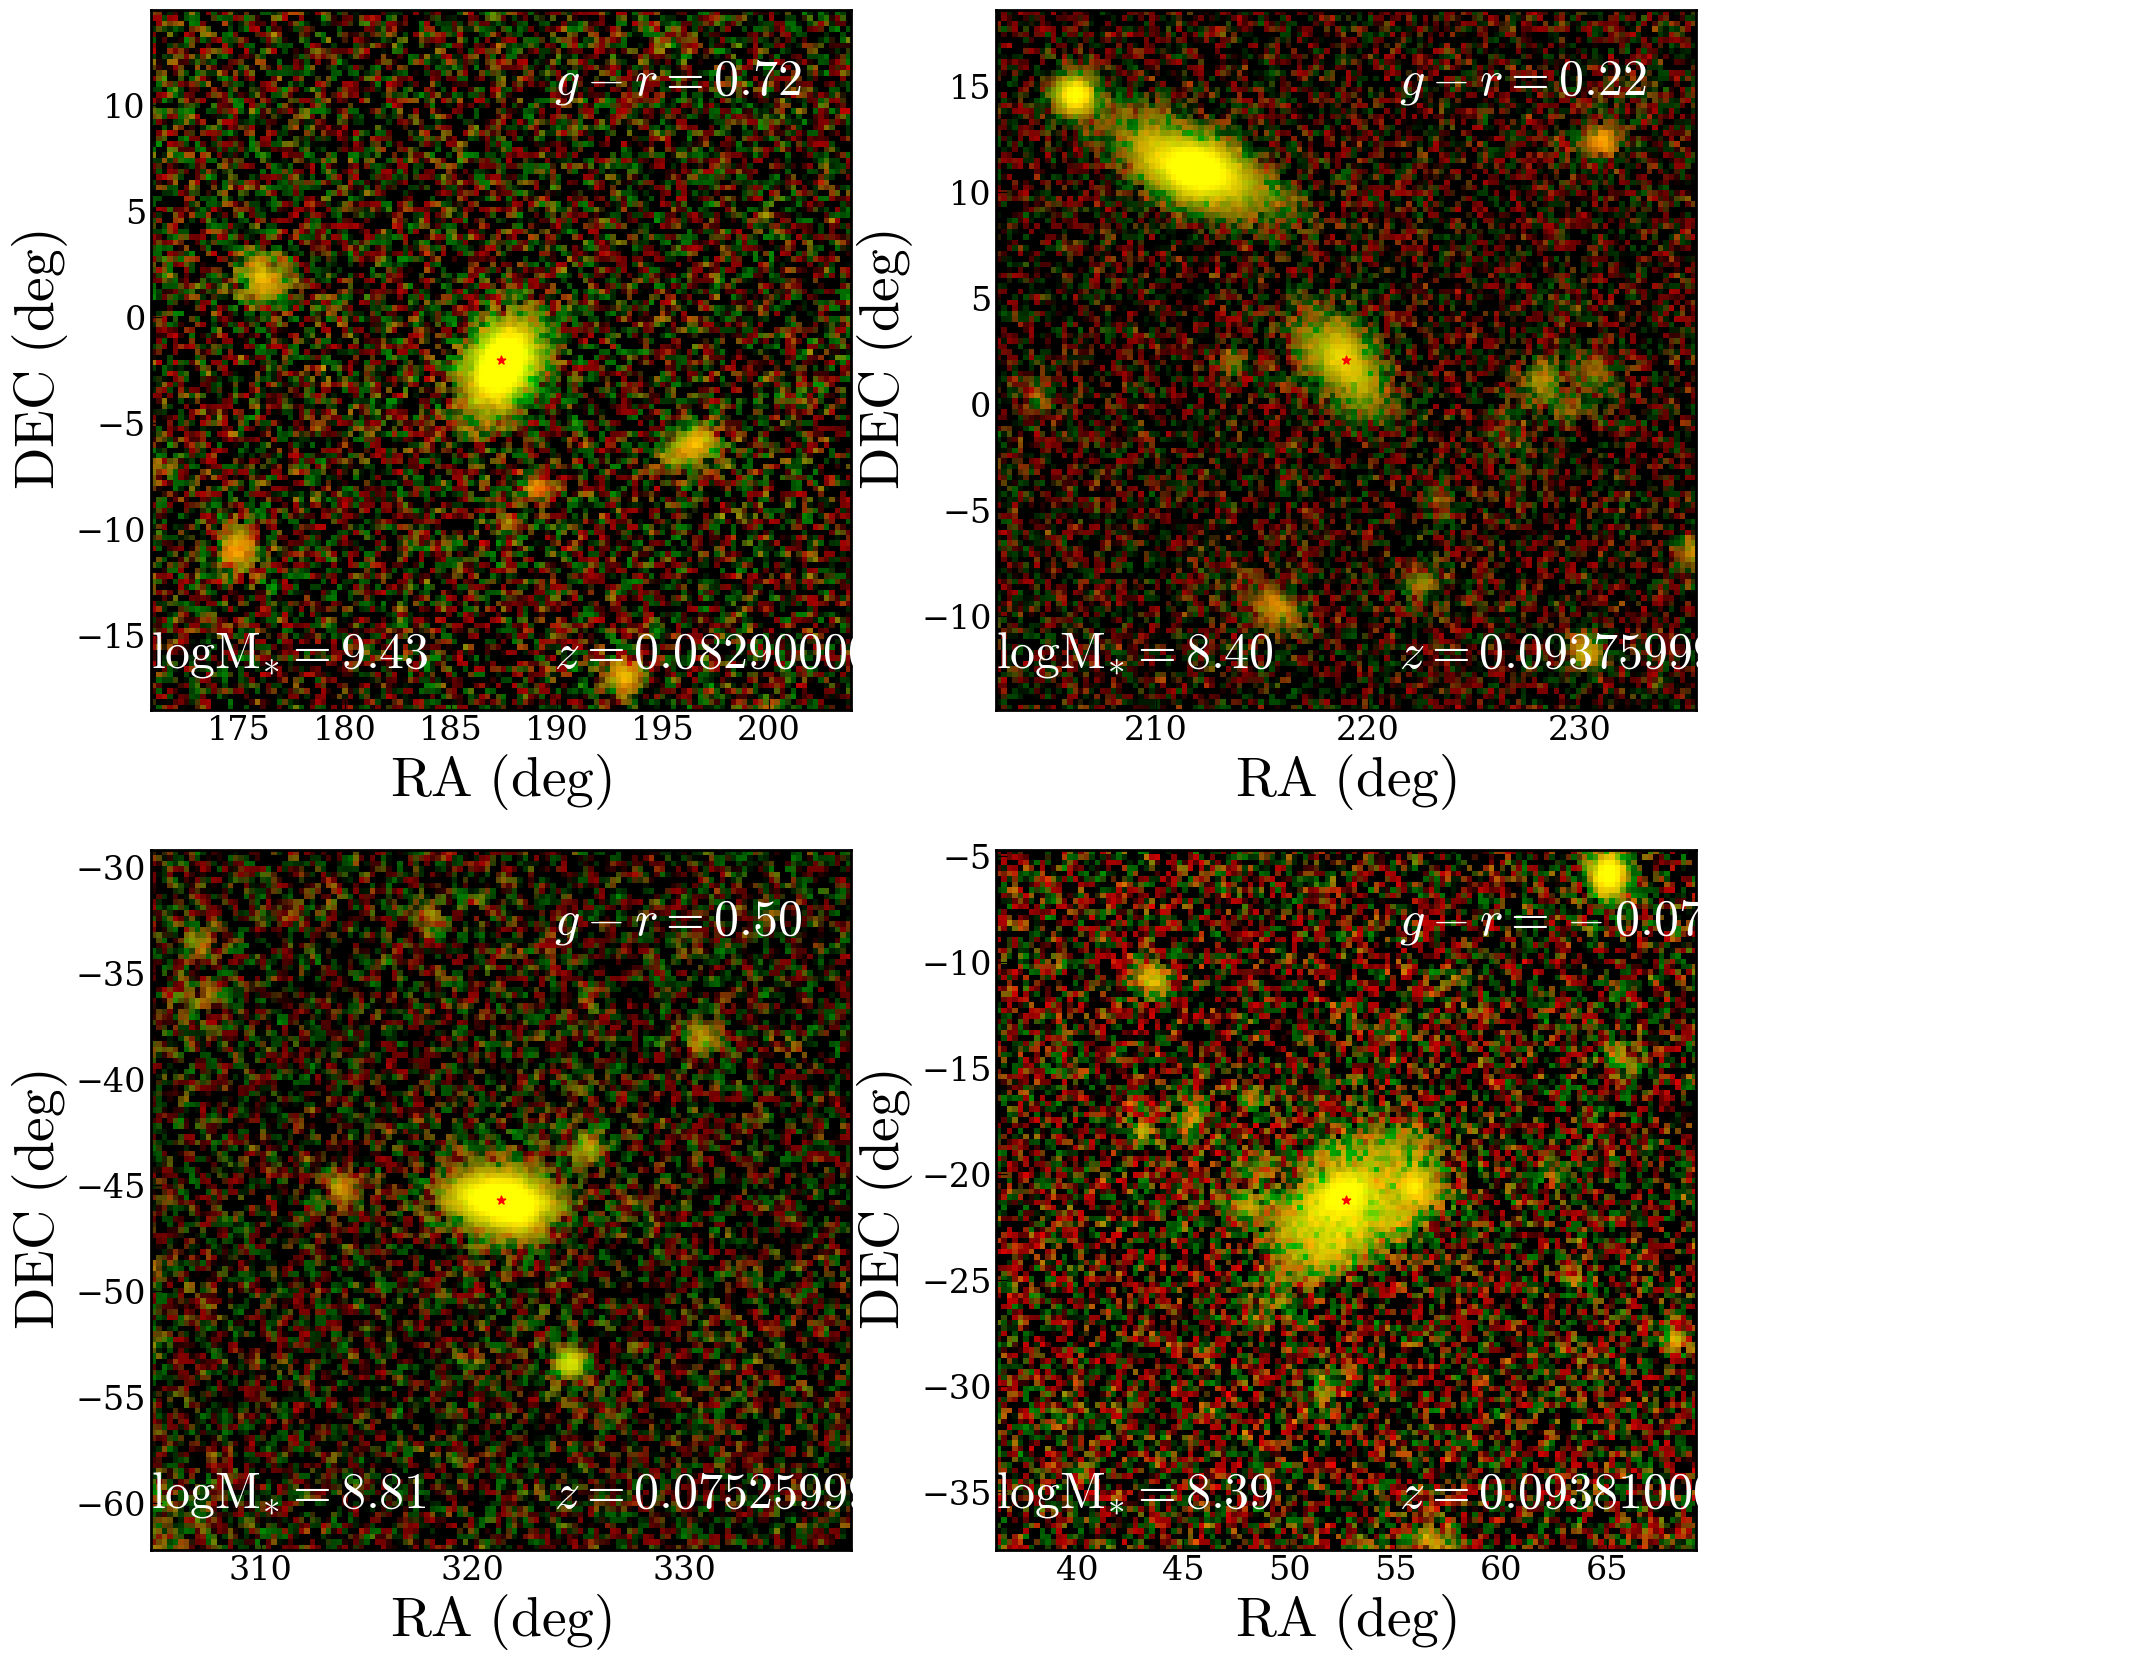

In [271]:
from astropy.convolution import convolve

four_sources = sources.sample(n=4)

fig,ax=plt.subplots(2,2,figsize=(20,20))

n=0
for ii,key in four_sources.iterrows():
        pos = np.array([key['RA'],key['DEC']])
        print(ii,pos,key['zspec'],key['logM'])
        pos_coord = SkyCoord(ra=pos[0]*u.degree, dec=pos[1]*u.degree, frame='icrs')
        
        download_cutout(pos.reshape(1,2))

        filename = 'cutout_{:.4f}_{:.4f}.fits'.format(pos[0],pos[1])
        #print(filename)
        try: data = fits.open("cutouts/"+filename)
        except: continue
        #convolve(img_data[i], model_psf)

        img_data,img_hdr,img_rms,glob_rms,flags = image_bkg(data)
        rgb_img = rgb_cutout(img_data)        
        ax[n//2,n%2].imshow(rgb_img, origin='lower',extent=[pos[0]-16.506,pos[0]+16.506, pos[1]-16.506, pos[1]+16.506])
        ax[n//2,n%2].scatter(pos[0], pos[1],marker='*',color='red',s=40,zorder=101)
        
        ax[n//2,n%2].text(pos[0]-16.5,pos[1]-14.5,r'${{\rm log}}M_{{\ast}}={0:.2f}$'.format(key['logM']),fontsize=36,color='white')
        ax[n//2,n%2].text(pos[0]+2.5,pos[1]-14.5,r'${{\it z}} ={0:.24}$'.format(key['zspec']),fontsize=36,color='white')
        ax[n//2,n%2].text(pos[0]+2.5,pos[1]+12.5,r'${{\it g-r}}={0:.2f}$'.format(key['g-r']),fontsize=36,color='white')
        
        ax[n//2,n%2].set_xlabel(r'$RA \ (deg)$',fontsize=40)
        ax[n//2,n%2].set_ylabel(r'$DEC \ (deg)$',fontsize=40)

        n+=1

plt.savefig('SAGAbg_4samp.pdf',bbox_inches='tight')
plt.show()

In [ ]:
def image_bkg(img_dat,c=['g','r','i','z']):
    img_sub = []
    img_rms = []
    glob_rms = []

    img_arr = img_dat[0].data
    img_hdr = img_dat[0].header
    img_invvar = img_dat[1].data

    flags=[False]*4 


    w = wcs.WCS(img_hdr,naxis=2)
   
    for i,key in enumerate(bands):

        bkg = sep.Background(img_arr[i,:,:].astype(img_arr[i,:,:].dtype.newbyteorder('=')))
        var = np.reciprocal(img_invvar[i,:,:])
        
        print(key+' Background:',bkg.globalback,key+' RMS^2:',np.square(bkg.globalrms),key+' Var:',np.mean(var))
        glob_rms.append(bkg.globalrms)
                
        bkg_image,bkg_rms = bkg.back(),bkg.rms()
        
        img_sub.append(img_arr[i,:,:] - bkg_image)
        img_rms.append(np.sqrt(var))

        if np.mean(var)>100: flags[i]=True


    return np.stack(img_sub,0),img_hdr, np.stack(img_rms,0),glob_rms,flags

morph_par = []

for ii,key in sources.iterrows():
        if ii>10000: continue
        pos = np.array([key['RA'],key['DEC']])
        print(ii,pos,key['zspec'],key['logM'])
        pos_coord = SkyCoord(ra=pos[0]*u.degree, dec=pos[1]*u.degree, frame='icrs')
        
        download_cutout(pos.reshape(1,2))

        filename = 'cutout_{:.4f}_{:.4f}.fits'.format(pos[0],pos[1])
        #print(filename)
        try: data = fits.open("cutouts/"+filename)
        except: continue

        img_data,img_hdr,img_rms,glob_rms,flags = image_bkg(data)

        if (flags[0] or flags[1] or flags[3]): continue
     
        #ns_pos = np.array([key['NS_RA'],key['NS_DEC']])
        #print(ns_pos)
        #get_star_psf(ns_pos

        #fig,ax=plt.subplots(1,4,figsize=(24,8),sharey=True)

        w = wcs.WCS(img_hdr,naxis=2)
        wc = [int(i) for i in w.world_to_pixel(pos_coord)]

        segmaps_hi,segmaps_lo = [],[]
        #n_obj = np.zeros(4)
        for jj in range(4):
                if flags[jj]==True: continue
                #image_plot(ax[jj],img_data[jj],cmp=mcm.Greys)
                objects,seg_map = sep.extract(img_data[jj], 1, err=img_rms[jj], segmentation_map=True,deblend_cont=0.0005,filter_type='matched',filter_kernel=model_psf)
                n_obj = len(objects['x'])
                if n_obj<1: 
                    flags[jj]==True
                    continue
                target = np.argmin(np.sqrt((objects['x']-wc[0])**2+(objects['y']-wc[1])**2))
                segmaps_lo.append(1*(seg_map==(target+1)))
                #print(hi_seg)

                objects,seg_map = sep.extract(img_data[jj], 4, err=img_rms[jj], segmentation_map=True,deblend_cont=0.001,filter_type='matched',filter_kernel=model_psf)
                n_obj = len(objects['x'])
                if n_obj<1: 
                    flags[jj]==True
                    continue
                target = np.argmin(np.sqrt((objects['x']-wc[0])**2+(objects['y']-wc[1])**2))
                segmaps_hi.append(1*(seg_map==(target+1)))

        if (flags[0] or flags[1] or flags[3]): continue

        if flags[2]==False: 
            comp_segmap = (segmaps_lo[0]&segmaps_lo[1])&(segmaps_lo[2]|segmaps_lo[3])&(segmaps_hi[0]&segmaps_hi[1])&(segmaps_hi[2]|segmaps_hi[3])
            all_segmap = (segmaps_lo[0]|segmaps_lo[1])|(segmaps_lo[2]|segmaps_lo[3])|(segmaps_hi[0]|segmaps_hi[1])|(segmaps_hi[2]|segmaps_hi[3])
        else: 
            comp_segmap = (segmaps_lo[0]&segmaps_lo[1])&(segmaps_lo[2])&(segmaps_hi[0]&segmaps_hi[1])&(segmaps_hi[2])
            all_segmap = (segmaps_lo[0]|segmaps_lo[1])|(segmaps_lo[2])|(segmaps_hi[0]&segmaps_hi[1])|(segmaps_hi[2])


        if comp_segmap[npix//2 -1,npix//2 -1]<1: continue
        
        fig,ax=plt.subplots(figsize=(16,8))

        rgb_img = rgb_cutout(img_data)
        #ax[0].imshow(rgb_img, origin='lower')
        #ax.imshow(comp_segmap, origin='lower')
        #ax[0].scatter(wc[0], wc[1],marker='*',color='red',s=40,zorder=101)
        
        morph_arr = np.zeros((4,12))
        petro_arr = np.zeros((4,5))

        img_copy = [img_data[k].copy() for k in range(3)]
        for k in range(3): np.putmask(img_copy[k],~(comp_segmap.astype('bool')),0)

        ax.imshow(rgb_cutout(img_copy), origin='lower',extent=[pos[0]-16.506,pos[0]+16.506, pos[1]-16.506, pos[1]+16.506])
        #ax.scatter(pos[0], pos[1],marker='*',color='red',s=40,zorder=101)
        for jj in range(4):
            morph = statmorph.source_morphology(img_data[jj], comp_segmap, weightmap=img_rms[jj])[0]

            #snr = signal_to_noise(img_data[jj],img_rms[jj],comp_segmap)
            ar_petro2 = 4*np.pi*morph.rpetro_ellip*morph.rpetro_ellip*(1-morph.ellipticity_asymmetry)
            segmap_frac = np.sum(comp_segmap)/ar_petro2

            print(np.sum(comp_segmap),ar_petro2,segmap_frac)
            morph_arr[jj,:] = ii,morph.gini,morph.m20,morph.gini_m20_bulge,morph.gini_m20_merger,morph.concentration,morph.asymmetry,morph.smoothness,morph.shape_asymmetry,morph.flag,morph.sn_per_pixel,segmap_frac
            petro_arr[jj,:] = morph.xc_asymmetry,morph.yc_asymmetry,morph.rpetro_ellip,morph.orientation_asymmetry,morph.ellipticity_asymmetry

            #in_petro = np.where(comp_segmap>0)
            #rd_petro = np.square((in_petro[0]-morph.xc_asymmetry)/morph.rpetro_ellip)+np.square((in_petro[1]-morph.yc_asymmetry)/(morph.rpetro_ellip*(1-morph.ellipticity_asymmetry)))
            #print(len(np.where(rd_petro<4)[0])/ar_petro2)

        pos_asymm = w.pixel_to_world_values(petro_arr[1,0], petro_arr[1,1])
        ax.scatter(pos_asymm[0], pos_asymm[1],marker='*',color='red',s=40,zorder=101)

        for l in [1,2]:
            e = Ellipse(xy=[pos_asymm[0], pos_asymm[1]],
                width=l*petro_arr[1,2]*pixsc, height=l*petro_arr[1,2]*(1-petro_arr[1,4])*pixsc,
                angle=petro_arr[1,3] * 180/np.pi,lw=2, fill=False,color='azure',ls='--')
            ax.add_artist(e)
        ax.text(pos[0]-16.5,pos[1]-14.5,r'${{\rm log}}M_{{\ast}}={0:.2f}$'.format(key['logM']),fontsize=30,color='white')
        ax.text(pos[0]+2.5,pos[1]-14.5,r'$z ={0:.2f}$'.format(key['zspec']),fontsize=30,color='white')
        ax.text(pos[0]+2.5,pos[1]+12.5,r'${{\it g-r}}={0:.2f}$'.format(key['g-r']),fontsize=30,color='white')

        ax.set_xlabel(r'$RA \ (deg)$',fontsize=40)
        ax.set_ylabel(r'$DEC \ (deg)$',fontsize=40)

    
        plt.savefig('post_cutouts/galseg_{:.4f}_{:.4f}.png'.format(pos[0],pos[1]),bbox_inches='tight')
        #plt.show()

        morph_par.append(morph_arr)


In [ ]:


fig1,ax1=plt.subplots(1,4,figsize=(32,10),sharey=True)

hdex = [-2.0,-0.5,0.3,1.0]

M20_arr = np.linspace(-2,-0.5,11)
M20_arrhalf = np.linspace(-2,-1.68,11)


for i in range(4):

    mst = sources['SERSIC'].iloc[morph_all[high_snr,i,0]]
    #dst = np.power(10,sources['logD'].iloc[morph_all[high_snr,i,0]])

    #non_merg = high_snr[np.where(morph_all[high_snr,i,1]<np.minimum(hubble_line(morph_all[high_snr,i,2]),merger_line(morph_all[high_snr,i,2])) )[0]]
    #med_m20,med_gini = np.median(morph_all[non_merg,i,2]),np.median(morph_all[non_merg,i,1])
    #print(med_m20,med_gini)

    hss_arr = hess_arr(morph_all[high_snr,i,2],morph_all[high_snr,i,1],1.0,hdex,80)
    #print(np.sum(hss_arr[j,:,:] ),np.amax(hss_arr[j,:,:] ),np.amin(hss_arr[j,:,:] ))
    ax1[i].imshow(hss_arr,cmap='viridis',aspect='auto',extent = hdex,origin='lower',interpolation='gaussian',norm=mcol.LogNorm(vmax=np.amax(hss_arr),vmin=1e-6))

    #ax1[i].scatter(morph_all[high_snr,i,2]-med_m20,morph_all[high_snr,i,1]-med_gini,c=mst,s=120,cmap=filt_cmap[i],vmin=0.5,vmax=3.5,edgecolors='black')

    #ax1[i].set_ylim((-0.1,0.5))
    #ax1[i].set_xlim((-0.5,1.5))
    ax1[i].plot(M20_arr,merger_line(M20_arr),lw=4,ls='--',color='black')
    ax1[i].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=4,ls='--',color='black')
    ax1[i].set_xlabel(r'$M_{20}$',fontsize=40)


ax1[0].set_ylabel( r'${\it Gini}$',fontsize=40)